# Projeto Text Mining
### Grupo 15:
- André Filipe Silva, 20230972
- Guilherme Moreira, 20230538
- João Gonçalves, 20230560
- João Pedro Mota, 20230454

In [1]:
##### PYTHON IMPORTS #####
import os
import time
import tempfile
from tempfile import NamedTemporaryFile
import gc
import logging
import itertools
import warnings
import csv
from configparser import ConfigParser
import psutil
import threading
import sys

from IPython.display import display, Javascript

##### NUMPY & PANDAS IMPORTS #####
import numpy as np
import pandas as pd
from pandas.errors import SettingWithCopyWarning

##### MATPLOTLIB IMPORTS #####
import matplotlib.pyplot as plt

##### RE, STRING & DEMOJI IMPORTS #####
import re
import string
import demoji
import emoji

##### NLTK IMPORTS #####
import nltk
from nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize

##### WORDCLOUD IMPORTS #####
from wordcloud import WordCloud

##### TQDM IMPORTS #####
from tqdm import tqdm

##### LANGDETECT IMPORTS #####
from langdetect import detect

##### LANGCODES IMPORTS #####
from langcodes import Language, LanguageTagError

##### DEEP_TRANSLATOR IMPORTS #####
from deep_translator import GoogleTranslator

##### SPACY IMPORTS #####
import spacy

##### PICKLE IMPORTS #####
import pickle

##### TORCH IMPORTS #####
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch.nn import BCEWithLogitsLoss, BCELoss
from torch.optim import Adam
import torch.nn as nn
import torch.nn.functional as F
import torchtext.vocab as vocab

##### TRANSFORMERS IMPORTS #####
from transformers import (AutoTokenizer, AutoModel, pipeline,
                          DistilBertForSequenceClassification, DistilBertTokenizer, 
                          Seq2SeqTrainer, DataCollatorForSeq2Seq, AutoModelForSeq2SeqLM, 
                          AutoModelForSequenceClassification, Seq2SeqTrainingArguments,
                          TFAutoModelForSequenceClassification, AutoConfig)

from sentence_transformers import SentenceTransformer

##### HUGGINGFACE_HUB IMPORTS #####
from huggingface_hub import notebook_login

##### TENSORFLOW & KERAS IMPORTS #####
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import (Dense, LSTM, Embedding, Input, concatenate, Flatten, Dropout, 
                          Conv1D, MaxPooling1D, GlobalMaxPooling1D, GlobalAveragePooling1D)

##### SKLEARN IMPORTS #####
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.metrics import (classification_report, f1_score, roc_auc_score, 
                             accuracy_score, confusion_matrix, ConfusionMatrixDisplay)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.manifold import TSNE


##### IMBALANCE_LEARN IMPORTS #####
from imblearn.under_sampling import RandomUnderSampler

##### GENSIM IMPORTS #####
import gensim  
from gensim.models import Word2Vec
from gensim.models.callbacks import CallbackAny2Vec

##### SCIPY IMPORTS #####
from scipy.special import softmax

##### PLOTLY IMPORTS #####
import plotly.graph_objects as go

##### EVALUATE IMPORTS #####
import evaluate

##### CYTHON IMPORTS #####
import cython

##### SET SEEDS #####
tf.random.set_seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

##### DEVICE SETUP #####
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

##### NLTK DOWNLOADS #####
#nltk.download("punkt")
#nltk.download("stopwords")
#nltk.download("wordnet")

#### Auxiliary Functions

In [2]:
# Auxiliary function for confusion matrix plotting

def plot_conf_matrix(y_true, y_pred, labels=["Not Unlisted", "Unlisted"], plot_name="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(plot_name)
    plt.show()

In [3]:
# Function to detect language of the comment

def detect_and_return_language(text):
    try:
        detected_lang_code = detect(text)
        lang = Language.get(detected_lang_code)
        return lang.display_name().lower()
    except ValueError:
        raise ValueError("Language code not found")

In [4]:
# Function to check if any contraction exists in a text

def contains_contractions(text, contractions_list):
    for contraction in contractions_list:
        if contraction in str(text):
            return True
    return False

contractions_dict = {
    "ain't": "am not",
    "aren't": "are not",
    "can't": "cannot",
    "couldn't": "could not",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'll": "he will",
    "he's": "he is",
    "I'd": "I would",
    "I'll": "I will",
    "I'm": "I am",
    "I've": "I have",
    "isn't": "is not",
    "it's": "it is",
    "let's": "let us",
    "mustn't": "must not",
    "shan't": "shall not",
    "she'd": "she would",
    "she'll": "she will",
    "she's": "she is",
    "shouldn't": "should not",
    "that's": "that is",
    "there's": "there is",
    "they'd": "they would",
    "they'll": "they will",
    "they're": "they are",
    "they've": "they have",
    "we'd": "we would",
    "we'll": "we will",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "where's": "where is",
    "who'd": "who would",
    "who'll": "who will",
    "who're": "who are",
    "who's": "who is",
    "who've": "who have",
    "won't": "will not",
    "wouldn't": "would not",
    "you'd": "you would",
    "you'll": "you will",
    "you're": "you are",
    "you've": "you have",
    }
contractions_list = list(contractions_dict.keys())

# Function to expand contractions
def expand_contractions(text):
    # Regular expression pattern to find contractions
    contractions_pattern = re.compile(
        "({})".format("|".join(contractions_dict.keys())),
        flags=re.IGNORECASE | re.DOTALL,
    )

    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = (
            contractions_dict.get(match)
            if contractions_dict.get(match)
            else contractions_dict.get(match.lower())
        )
        if expanded_contraction is None:
            expanded_contraction = match
        else:
            expanded_contraction = first_char + expanded_contraction[1:]
        return expanded_contraction

    # Replace contractions with their expanded forms
    expanded_text = contractions_pattern.sub(expand_match, text)
    return expanded_text

In [5]:
# EXTRA METHOD - CONVERTING EMOJIS TO TEXT

def emoji_to_text(text):
    """
    Convert emojis to text
    """

    text = emoji.demojize(text)

    # Replace underscores in emoji descriptions with spaces
    text = re.sub(r'_', ' ', text)
    
    # Insert spaces around the emoji text descriptions (delimited by colons)
    text = re.sub(r'(:\S+?:)', r' \1 ', text)

    # Remove multiple spaces if they occur
    text = re.sub(r'\s+', ' ', text)

    # Remove any spaces at beginning or end
    return text.strip()

In [6]:
# Function to clean data
# Using regex to remove html tags, money symbols, dates among others

def clean_df(df):

    copy_df = df.copy()
    

    # to better visualise the following regular expressions please visit: https://extendsclass.com/regex-tester.html#python
    html_tag_regex = r"<\W*[a-zA-Z]{1,8}\s*\W*>"

    date_regex = r"\d{2}/\d{2}/(\d{4}|\d{2})|((\d{4}|\d{2})/\d{2}/\d{2})"

    time_regex = (r"\b((\d{1,2}((?:h|H|:|-)\d{2}(min)?)(?:AM|PM)?)|(\d{1,2}\s*(?:AM|PM|h|H)))\b")

    regex_for_monetary_values = r"^(\b((?:€|EUR|\$|USD|GBP|£|JPY|¥)\s*(?:\d+(?:\.\d{1,2})?|\.\d{1,2}))\b|\b((?:\d+(?:\.\d{1,2})?|\.\d{1,2})\s*(?:€|EUR|\$|USD|GBP|£|JPY|¥))\b)$"


    col_index_dict = {}
    # print column name and its index
    for i, col in enumerate(copy_df.columns):
        col_index_dict[col] = i


    for i in tqdm(range(len(copy_df))):
        comment_index = col_index_dict["comments"]
        house_description_index = col_index_dict["description"]
        host_about_index = col_index_dict["host_about"]


        # get the text
        comment = str(copy_df.iloc[i, comment_index])
        house_descrp = str(copy_df.iloc[i, house_description_index])
        host_about = str(copy_df.iloc[i, host_about_index])
        
        # Check for Contractions
        comment_contains_contraction_boolean = col_index_dict["comments_contains_contraction"]
        house_description_contains_contraction_boolean = col_index_dict["description_contains_contraction"]
        host_about_contains_contraction_boolean = col_index_dict["host_about_contains_contraction"]


        # Turning emojis into text - EXTRA PREPROCESSING METHOD
        comment = emoji_to_text(comment)
        house_descrp = emoji_to_text(house_descrp)
        host_about = emoji_to_text(host_about)

        # remove html tags
        comment = re.sub(html_tag_regex, " ", comment)
        house_descrp = re.sub(html_tag_regex, " ", house_descrp)
        host_about = re.sub(html_tag_regex, " ", host_about)

        # remove monetary references
        comment = re.sub(regex_for_monetary_values, "MONETARY_VALUE_STAMP", comment)
        house_descrp = re.sub(regex_for_monetary_values, "MONETARY_VALUE_STAMP", house_descrp)
        host_about = re.sub(regex_for_monetary_values, "MONETARY_VALUE_STAMP", host_about)

        # Change dates to DATE
        comment = re.sub(date_regex, "DATE_STAMP", comment)
        house_descrp = re.sub(date_regex, "DATE_STAMP", house_descrp)
        host_about = re.sub(date_regex, "DATE_STAMP", host_about)

        # remove time references
        comment = re.sub(time_regex, "TIME_STAMP", comment)
        house_descrp = re.sub(time_regex, "TIME_STAMP", house_descrp)
        host_about = re.sub(time_regex, "TIME_STAMP", host_about)

        # remove punctuation
        comment = re.sub(r'[^\w\s]', ' ', comment)
        house_descrp = re.sub(r'[^\w\s]', ' ', house_descrp)
        host_about = re.sub(r'[^\w\s]', ' ', host_about)

        # lower case everything
        comment = comment.lower()
        house_descrp = house_descrp.lower()
        host_about = host_about.lower()

        # Check for Contractions and Expand them
        if comment_contains_contraction_boolean:
            comment = expand_contractions(comment)
        if house_description_contains_contraction_boolean:
            house_descrp = expand_contractions(house_descrp)
        if host_about_contains_contraction_boolean:
            host_about = expand_contractions(host_about)
        
        # Check for 'x000d' in text and remove
        if "x000d" in str(comment):
            comment = comment.replace("x000d", "")
        if "x000d" in str(house_descrp):
            house_descrp = house_descrp.replace("x000d", "")
        if "x000d" in str(host_about):
            host_about = host_about.replace("x000d", "")

        # tokenize
        comment = word_tokenize(comment)
        house_descrp = word_tokenize(house_descrp)
        host_about = word_tokenize(host_about)

        # remove stop words
        stop = set(stopwords.words('english'))
        comment = [word for word in comment if word not in stop]
        house_descrp = [word for word in house_descrp if word not in stop]
        host_about = [word for word in host_about if word not in stop]

        # join back to string
        comment = " ".join(comment)
        house_descrp = " ".join(house_descrp)
        host_about = " ".join(host_about)

        # update dataframe
        copy_df.iloc[i, col_index_dict["comments"]] = comment
        
        copy_df.iloc[i, col_index_dict["description"]] = house_descrp

        copy_df.iloc[i, col_index_dict["host_about"]] = host_about


    # drop contain_contraction columns
    if "comments_contains_contraction" in copy_df.columns:
        copy_df.drop(columns=["comments_contains_contraction"], inplace=True)
    if "description_contains_contraction" in copy_df.columns:
        copy_df.drop(columns=["description_contains_contraction"], inplace=True)
    if "host_about_contains_contraction" in copy_df.columns:
        copy_df.drop(columns=["host_about_contains_contraction"], inplace=True)


    return copy_df

In [7]:
# Function to merge all comments into same line for each property
# This is done to have all comments in a single cell for each property

def create_df_with_comments_and_target(df):
    """
    Converte os comentários de várias propriedades para uma única string, agrupando-os por listing_id.
    Devolve um dataframe com os comentários agrupados na mesma célula e a variável target.
    Args:
        df (pd.Dataframe): dataframe com os comentários de várias propriedades e a variável target.

    Returns:
        pd.Dataframe: dataframe com os comentários agrupados na mesma célula e a variável target.
    """
    df2 = df.copy()
    df2 = df2.groupby("listing_id").agg({"comments": ",".join, "unlisted": "first"}).reset_index()
    # for every listing_id add host_about and description
    df2["host_about"] = df2["listing_id"].apply(lambda x: df[df["listing_id"] == x]["host_about"].values[0])
    df2["description"] = df2["listing_id"].apply(lambda x: df[df["listing_id"] == x]["description"].values[0])
    return df2



# Same function but for test data

def create_df_with_comments(df):
    """O mesmo que em cima, mas para o test que n tem target
    PARA O DATASET DE PREDICTIONS!

    Args:
        df (pd.Dataframe): dataframe com os comentários de várias propriedades

    Returns:
        pd.Dataframe: dataframe com os comentários agrupados na mesma célula
    """
    df2 = df.copy()
    df2 = df2.groupby("listing_id").agg({"comments": ",".join, }).reset_index()
    # for every listing_id add host_about and description
    df2["host_about"] = df2["listing_id"].apply(lambda x: df[df["listing_id"] == x]["host_about"].values[0])
    df2["description"] = df2["listing_id"].apply(lambda x: df[df["listing_id"] == x]["description"].values[0])
    return df2

In [3]:
os.chdir(os.path.join("Project Corpora"))

In [9]:
#raw datasets
raw_train = pd.read_csv("train.csv")
raw_train_reviews = pd.read_csv("train_reviews.csv")

# Data Exploration - before preprocessing

In [10]:
raw_train.head(10)  

index                                        description  \
0      1  This is a shared mixed room in our hostel, wit...   
1      2  O meu espaço fica perto de Parque Eduardo VII,...   
2      3  Trafaria’s House is a cozy and familiar villa ...   
3      4  Apartamento Charmoso no Chiado, Entre o Largo ...   
4      5  Joli appartement  en bordure de mer.<br /> 2 m...   
5      6  IMPORTANT: In response to COVID-19, this prope...   
6      7  This is my home that I rent out when I'm trave...   
7      8  Find tranquility in this meticulously curated ...   
8      9  Charming apartment with one bedroom with doubl...   
9     10  Walk up original wooden stairs to the entrance...   

                                          host_about  unlisted  
0                Alojamento Local Registro: 20835/AL         0  
1  I am friendly host, and I will try to always b...         1  
2  I am a social person liking to communicate, re...         1  
3  Hello!_x000D_\nI m Portuguese and i love to me...         0  
4  Nous sommes une famille avec deux enfants de 1...         0  
5  Hi, we are Homing - a company that develops it...         0  
6  Globe trotter. I'm of Portuguese nationality w...         1  
7  I travel a lot and I love it. _x000D_\nOrigina...         0  
8  Isabel & Helder, portugueses, parents of three...         0  
9  Serviced holiday apartments casa in Azenhas do...         0

In [11]:
raw_train_reviews.head(10)

index                                           comments
0      1  this is a very cozy and comfortable house to s...
1      1                                          good<br/>
2      1  My first hostel experience, and all I have to ...
3      1  Das Hostel war neu und deshalb funktionierte a...
4      1  It was fine for a dorm, but I think for the pe...
5      1  Our stay in Lisbon Tip Hostel was very good. T...
6      1  Close to shops in town and a comfortable place...
7      1  Young and friendly staff. Great location along...
8      1  The place is just off the Parque metro stop wh...
9      1  Had a nice stay at this hostel. The beds were ...

In [12]:
raw_train_reviews.comments[0]

'this is a very cozy and comfortable house to stay in.never worry about the safety and the host is very nice.very close to parque metro station.easy to find.'

In [13]:
# Rename 'index' column to 'listing_id'
raw_train_reviews.rename(columns={"index": "listing_id"}, inplace=True)
raw_train.rename(columns={"index": "listing_id"}, inplace=True)

In [14]:
raw_train.shape

(6248, 4)

In [15]:
raw_train_reviews.shape

(361281, 2)

In [16]:
raw_train.isna().sum()

listing_id     0
description    0
host_about     0
unlisted       0
dtype: int64

In [17]:
raw_train_reviews.isna().sum()

listing_id    0
comments      2
dtype: int64

We need to drop NAs before converting column types otherwise they will stop being considered as NA and dropping will not work.<br>
We drop them bcause they are just 2. If they were many more we wouldn't drop them.

In [18]:
raw_train_reviews.dropna(subset=["comments"], inplace=True)

In [19]:
raw_train_reviews.isna().sum()

listing_id    0
comments      0
dtype: int64

In [20]:
listing_correct_types = {"description": str, "host_about": str}

reviews_correct_types = {"comments": str}

raw_train = raw_train.astype(listing_correct_types)
raw_train_reviews = raw_train_reviews.astype(reviews_correct_types)

### Unlisted

In [21]:
raw_train["unlisted"].unique()

array([0, 1], dtype=int64)

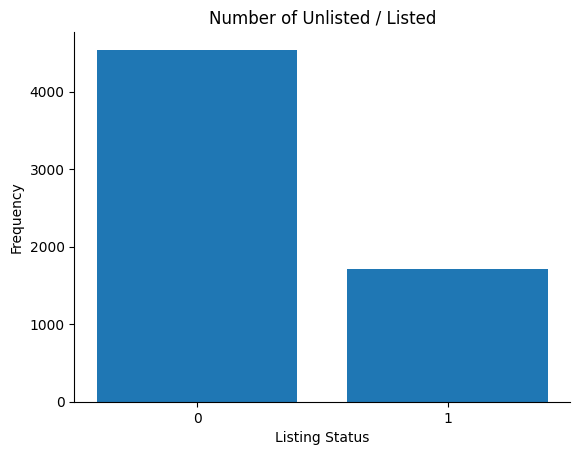

In [22]:
plt.bar(
    raw_train["unlisted"].value_counts().index,
    raw_train["unlisted"].value_counts().values,
)
plt.grid(False)
plt.title("Bar Chart of Listing Status")
plt.xlabel("Listing Status")
plt.ylabel("Frequency")
plt.xticks(np.arange(0,2))
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.show()

### Description

In [23]:
# Get size of description and order by biggest to smallest
raw_train["description"].apply(len).value_counts()

description
1000    3769
35        37
33        21
36        16
547       14
        ... 
143        1
68         1
977        1
696        1
695        1
Name: count, Length: 851, dtype: int64

In [24]:
# Get word count of description and order by biggest to smallest
raw_train["description_word_count"] = raw_train["description"].apply(lambda x: len(str(x).split(" ")))

raw_train["description_word_count"].value_counts()

description_word_count
166    184
165    176
164    172
162    163
163    162
      ... 
204      1
205      1
210      1
197      1
195      1
Name: count, Length: 198, dtype: int64

In [25]:
raw_train[raw_train["description_word_count"] == 3]["description"]

281      <b>License number</b><br />43084/AL
653      <b>License number</b><br />37710/AL
713      <b>License number</b><br />92019/AL
746        <b>License number</b><br />Exempt
899       <b>License number</b><br />6005/al
                        ...                 
5769     <b>License number</b><br />45360/AL
5869     <b>License number</b><br />60911/AL
5965     <b>License number</b><br />48184/AL
6068    <b>License number</b><br />123056/AL
6245       <b>License number</b><br />Exempt
Name: description, Length: 89, dtype: object

In [26]:
raw_train["description_word_count"].describe()

count    6248.000000
mean      132.860755
std        48.084904
min         3.000000
25%        99.000000
50%       157.000000
75%       167.000000
max       210.000000
Name: description_word_count, dtype: float64

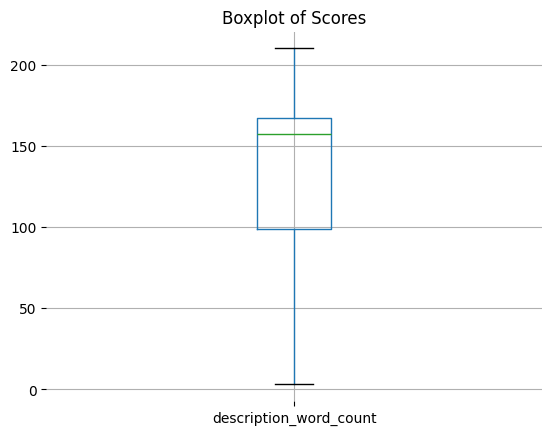

In [27]:
raw_train.boxplot(column=["description_word_count"])
plt.title("Boxplot of Scores")
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["bottom"].set_visible(False)
plt.gca().spines["left"].set_visible(False)
plt.show()

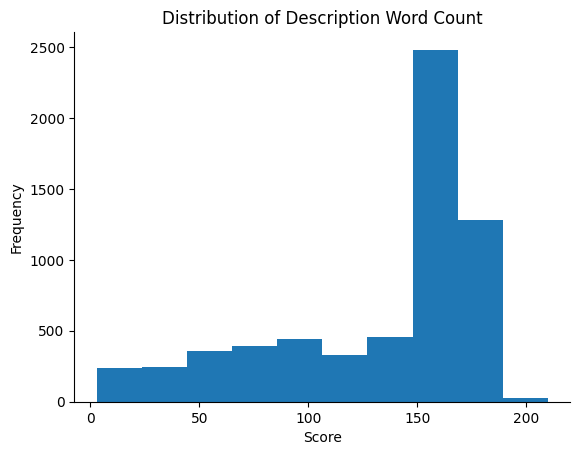

In [28]:
raw_train["description_word_count"].hist()
plt.grid(False)
plt.title("Distribution of Description Word Count")
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.show()

In [29]:
all_words = " ".join(raw_train["description"].str.lower()).split()

freq = pd.Series(all_words).value_counts()

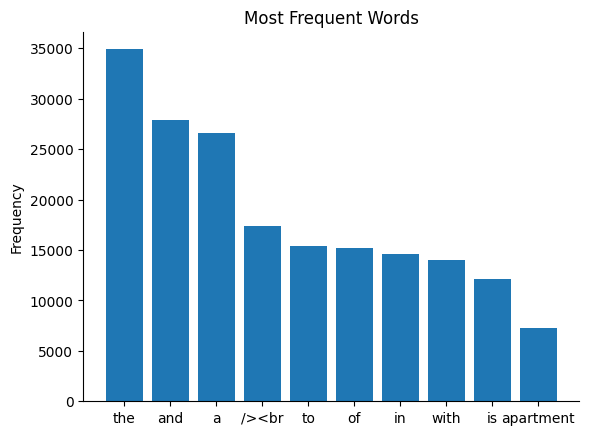

In [30]:
x_labels = freq.index[0:10]
values = freq[:10]
plt.bar(x_labels, values)
plt.xticks(x_labels)
plt.ylabel("Frequency")
plt.title("Most Frequent Words")
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.show()

### Comments

In [31]:
comment_counts = raw_train_reviews.groupby("listing_id")["comments"].count()

# Sort the counts in descending order
sorted_comment_counts = comment_counts.sort_values(ascending=False)

# Display the top 10 indices with the most comments
top_10_indices = sorted_comment_counts.head(10)
top_10_indices

listing_id
265     891
3396    765
1147    678
4106    617
954     583
3729    578
1246    576
5833    571
5532    559
3085    552
Name: comments, dtype: int64

In [32]:
# get character count of comments
raw_train_reviews["comment_character_count"] = raw_train_reviews["comments"].apply(len)
raw_train_reviews["comment_character_count"].value_counts()

comment_character_count
88      1334
87      1164
89      1055
83      1040
82      1031
        ... 
2171       1
2984       1
2821       1
3746       1
2034       1
Name: count, Length: 2489, dtype: int64

In [33]:
# from 3 characters onwards, the comments seem to be valid
raw_train_reviews[raw_train_reviews["comment_character_count"] == 3]["comments"].value_counts()

comments
Top    56
...    17
top    14
Bom    13
:-)     7
       ..
5*!     1
ooo     1
  C     1
non     1
Nan     1
Name: count, Length: 68, dtype: int64

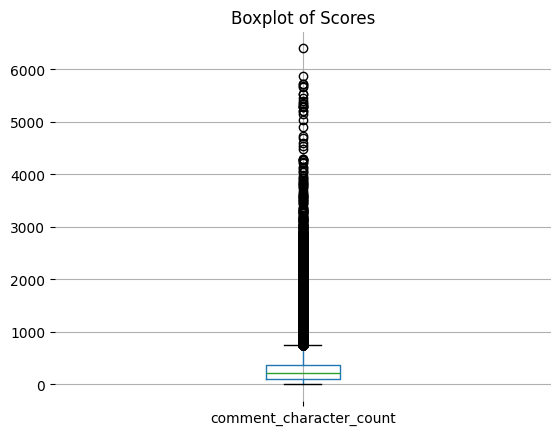

In [34]:
raw_train_reviews.boxplot(column=["comment_character_count"])
plt.title("Boxplot of Scores")
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["bottom"].set_visible(False)
plt.gca().spines["left"].set_visible(False)
plt.show()

In [35]:
freq = pd.Series(raw_train_reviews[raw_train_reviews["comment_character_count"] == 1]["comments"].value_counts())

c:\Users\andre\OneDrive\Documentos\Nova IMS\1º ano\2º Semestre\Text Mining\tm_env\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128077 (\N{THUMBS UP SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\andre\OneDrive\Documentos\Nova IMS\1º ano\2º Semestre\Text Mining\tm_env\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128076 (\N{OK HAND SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


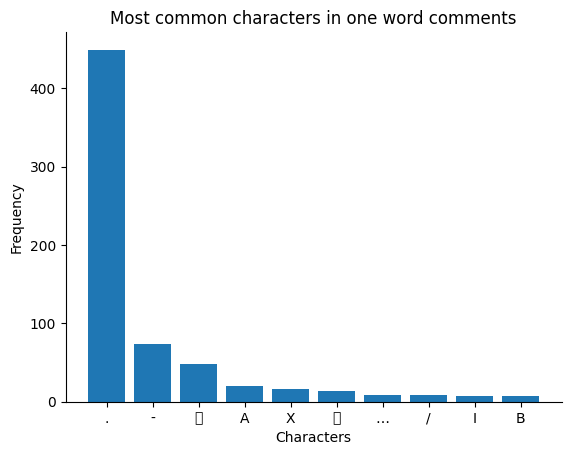

In [36]:
plt.bar(freq.index[:10], freq[:10])
plt.grid(False)
plt.title("Most common characters in one word comments")
plt.xlabel("Characters")
plt.ylabel("Frequency")
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.show();

In [37]:
# get word count of comments
raw_train_reviews["comment_word_count"] = raw_train_reviews["comments"].apply(lambda x: len(str(x).split(" ")))
raw_train_reviews["comment_word_count"].value_counts()

comment_word_count
14     6232
13     5793
9      5691
11     5687
10     5627
       ... 
552       1
939       1
627       1
580       1
784       1
Name: count, Length: 595, dtype: int64

In [38]:
# Even 1-worded comments seem valid (apart from non-alphabetical ones, obviously)
raw_train_reviews[raw_train_reviews["comment_word_count"] == 1]["comments"][:10]

1                                              good<br/>
39                                                   top
65                                            Recomendo.
145    房东非常体贴，而且房东的设计也非常好，我们非常喜欢他的地点，而且回答得很及时。<br/>我会...
159                               交通方便<br/>地方整潔<br/>有乾衣機
275                                                    .
317                                                    I
432                                                    👍
580                                                 Good
682                                                    .
Name: comments, dtype: object

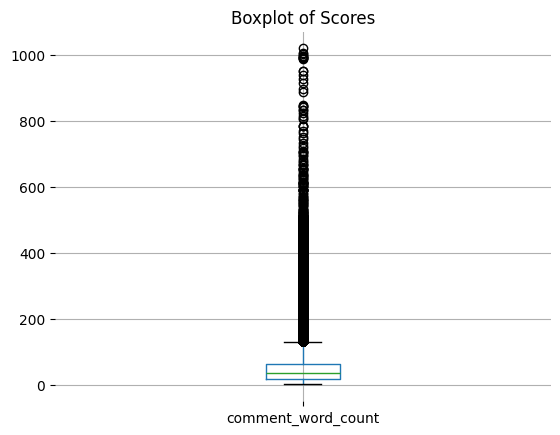

In [39]:
raw_train_reviews.boxplot(column=["comment_word_count"])
plt.title("Boxplot of Scores")
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["bottom"].set_visible(False)
plt.gca().spines["left"].set_visible(False)
plt.show()

In [40]:
all_comment_words = " ".join(raw_train_reviews["comments"].str.lower()).split()

freq = pd.Series(all_comment_words).value_counts().sort_values(ascending=False)

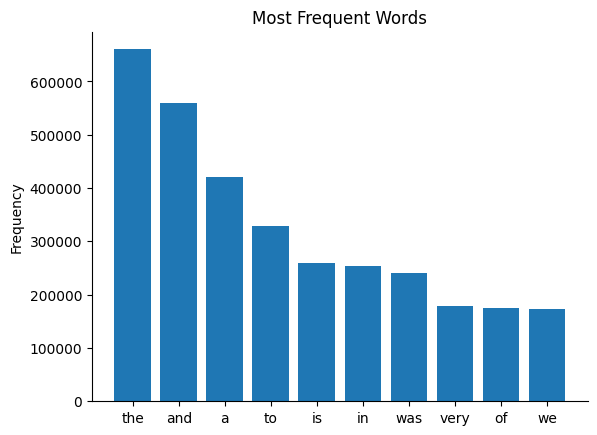

In [41]:
x_labels = freq.index[0:10]
values = freq[:10]
plt.bar(x_labels, values)
plt.xticks(x_labels)
plt.ylabel("Frequency")
plt.title("Most Frequent Words")
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.show()

In [42]:
# check for duplicates by 'listing_id' and 'comments', and show rows
duplicated_rows = raw_train_reviews[raw_train_reviews.duplicated(["listing_id", "comments"])]

duplicated_rows[["listing_id", "comments", "comment_word_count"]].sort_values("comment_word_count", ascending=False)[:10]

listing_id                                           comments  \
58173          987  Leider hat uns eine Coronainfektion während de...   
36950          651  Pas d'eau chaude pendant 4jours, on nous suggè...   
232323        3959  Lincoln and Cameron’s flat is true gem. It’s l...   
171194        2886  João Cunha é simplesmente um anfitrião super a...   
13421          265  Maria and João were incredible; it was the bes...   
48170          842  We LOVED staying here! We stayed here already ...   
84893         1423  Cozy, comfortable, good value apartment in a l...   
49932          876  Had an excellent experience at hugo's apartmen...   
216177        3674  Love the apartment ，cozy tidy and stylish. The...   
346227        5969  Nice, clean room in an apartment shared with o...   

        comment_word_count  
58173                  184  
36950                  109  
232323                 103  
171194                  98  
13421                   89  
48170                   78  
84893                   49  
49932                   48  
216177                  47  
346227                  44

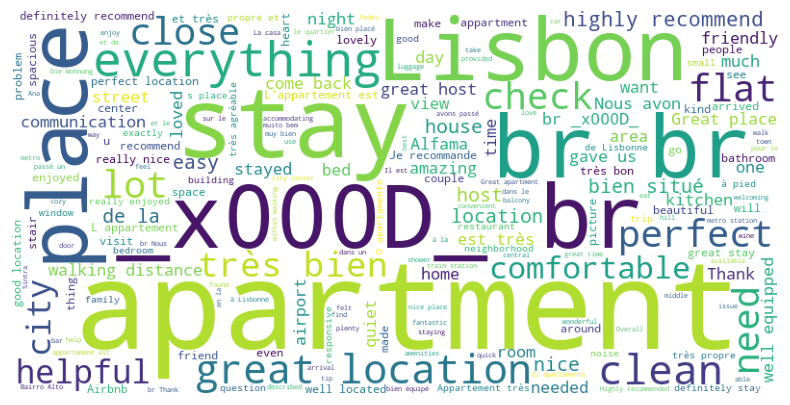

In [259]:
# Joining all the comments into a single string
all_reviews = " ".join(raw_train_reviews["comments"])

# Create WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(all_reviews)

# Plotting the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud)
plt.axis("off")
plt.show();

### Host_about

In [44]:
# get size of host_about
raw_train["host_about_character_count"] = raw_train["host_about"].apply(len)
raw_train["host_about_character_count"].value_counts()

host_about_character_count
706     153
673      98
842      68
434      66
266      49
       ... 
1389      1
566       1
409       1
1735      1
817       1
Name: count, Length: 919, dtype: int64

In [45]:
raw_train[raw_train["host_about_character_count"] == 6]["host_about"]

476     Dalma 
514     Alfama
2287    Lisboa
2481    Alfama
2887    Canada
2987    LUGANO
5421    morena
Name: host_about, dtype: object

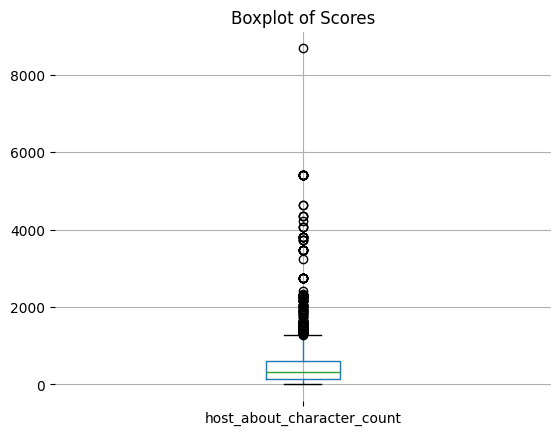

In [46]:
raw_train.boxplot(column=["host_about_character_count"])
plt.title("Boxplot of Scores")
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["bottom"].set_visible(False)
plt.gca().spines["left"].set_visible(False)
plt.show()

We decided not to show a bar plot of the `host_about_character_count` as there are many outliers (as seen above) and it would make the plot unreadable.

In [47]:
raw_train["host_about_word_count"] = raw_train["host_about"].apply(lambda x: len(str(x).split(" ")))

raw_train["host_about_word_count"].value_counts()

host_about_word_count
110    157
1      138
108    105
2      103
43      98
      ... 
231      1
161      1
330      1
281      1
241      1
Name: count, Length: 264, dtype: int64

In [48]:
# It's ok to say even from 1-worded host_about, it's still valid (apart from non-alphabetical ones, obviously)
raw_train[raw_train["host_about_word_count"] == 1]["host_about"]

85                           \n\n
92                              .
110                     _x000D_\n
193                    @ZMPoppe\n
351                         自驾游晚期
                  ...            
5965                          sss
5983                          sss
6048    Sports&NightLife_x000D_\n
6191              Perfeccionista.
6234                    Ruan&Chen
Name: host_about, Length: 138, dtype: object

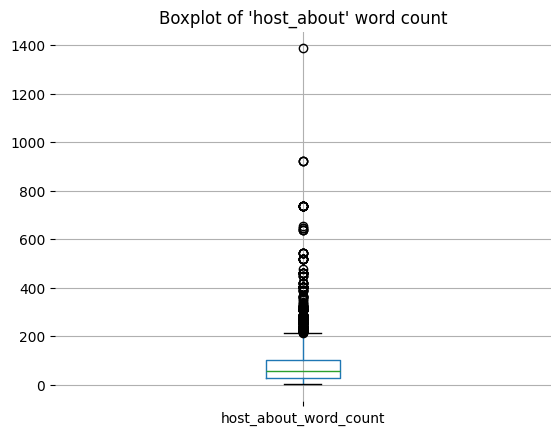

In [49]:
raw_train.boxplot(column=["host_about_word_count"])
plt.title("Boxplot of 'host_about' word count")
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["bottom"].set_visible(False)
plt.gca().spines["left"].set_visible(False)
plt.show()

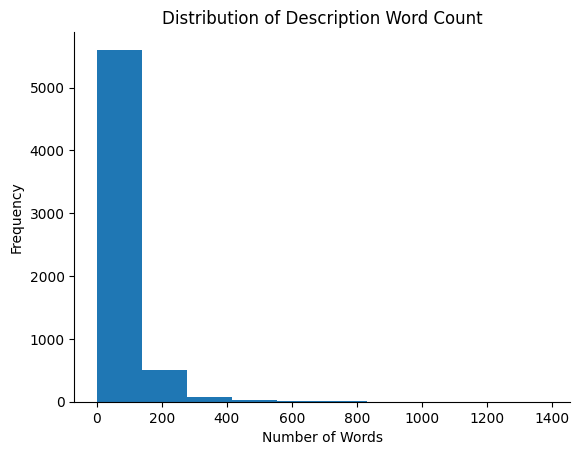

In [50]:
raw_train["host_about_word_count"].hist()
plt.grid(False)
plt.title("Distribution of Description Word Count")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.show()

In [51]:
all_words = " ".join(raw_train["host_about"].str.lower()).split()

freq = pd.Series(all_words).value_counts()

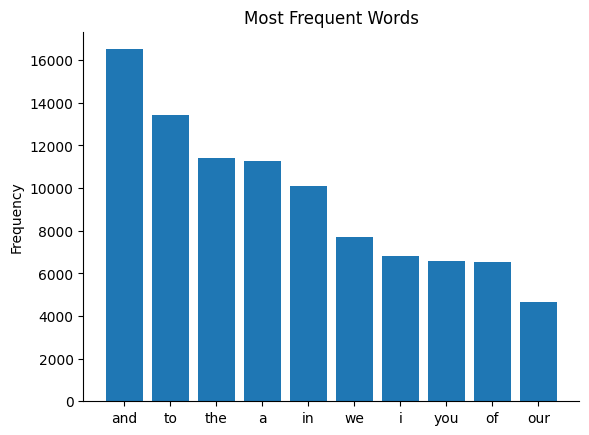

In [52]:
x_labels = freq.index[0:10]
values = freq[:10]
plt.bar(x_labels, values)
plt.xticks(x_labels)
plt.ylabel("Frequency")
plt.title("Most Frequent Words")
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.show()

##### We're going to check how many comments from each language we have

In [53]:
def detect_language(text):
    try:
        return detect(text)
    except:
        return 'Error'  # In case text is too short or any other issue

In [54]:
# Apply the language detection to the 'comment' column
tqdm.pandas()

raw_train_reviews["language"] = raw_train_reviews["comments"].progress_apply(detect_language)

raw_train_reviews.to_csv("train_reviews_with_langs.csv", index = False)

In [55]:
# Count the number of comments in each language
raw_train_reviews = pd.read_csv("train_reviews_with_langs.csv")

language_counts = raw_train_reviews["language"].value_counts()

print(language_counts)

language
en       232349
fr        53251
pt        22433
es        19233
de        14203
it         5686
nl         3582
ru         1501
ko         1468
zh-cn      1039
Error       918
ro          825
pl          597
ca          580
da          463
sv          373
af          348
no          304
so          280
cs          210
fi          203
id          163
tl          153
hu          137
ja          110
cy          100
he           89
zh-tw        88
hr           77
sw           73
sk           72
tr           64
lt           58
el           49
vi           45
uk           44
sl           39
et           22
bg           18
lv           12
ar            9
sq            8
mk            2
ur            1
Name: count, dtype: int64


# Data Preprocessing

#### Note - **EXTRA METHODS**: Translation to English, Emoji to Text Conversion

First, we translated all non-english `description` and `host about` to english on the `train.xlsx` file. We also translated to english the `comments` on the `train_reviews.xlsx` file. We applied the exact same procedure for the `test.xlsx` and `test_reviews.xlsx`, since they follow the same structure.

#### Translation 

On this section everything was changed from Python to 'raw' as we don't want it to run again (takes a long time)

In [56]:
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [57]:
train= pd.read_csv("train.csv")
train_reviews = pd.read_csv("train_reviews.csv")
test = pd.read_csv("test.csv")
test_reviews = pd.read_csv("test_reviews.csv")

Basic curation of rows with empty values

In [58]:
train.isna().sum()

In [59]:
train_reviews.isna().sum()

In [60]:
train_reviews.dropna(subset = "comments", inplace = True) # Just 2 comments were dropped, not worrisome
train_reviews.reset_index(inplace = True, drop = True)

In [61]:
train_reviews.isna().sum()

In [62]:
test.isna().sum()

In [63]:
test_reviews.isna().sum()

In [64]:
train.head(10)

`train` Translation

In [65]:
error = 0

train["description_en"] = np.nan
train["host_about_en"] = np.nan

columns = ["index", "description", "description_en", "host_about","host_about_en", "unlisted"]

train = train[columns]

In [66]:
train.head()

In [67]:
for i in tqdm(range(len(train))):
    try:
        # Attempt to translate the comment
        train["description_en"][i] = GoogleTranslator(source='auto', target='en').translate(text=train["description"][i])
        train["host_about_en"][i] = GoogleTranslator(source='auto', target='en').translate(text=train["host_about"][i])
    except Exception as e:
        # Log or handle translation errors
        error += 1
        train['description_en'][i]= train["description"][i]
        train["host_about_en"][i] = train["host_about"][i]
        
        print(f"Translation failed at index {i}: {e}")

print(f"Translation ended with {error} errors.")

In [68]:
train.to_csv("train_en.csv", index = False)

In [69]:
train.head()

`train_reviews` Translation

In [70]:
train_reviews.head()

In [71]:
error = 0

train_reviews["comments_en"] = np.nan

In [72]:
for i in tqdm(range(len(train_reviews))):
    try:
        # Attempt to translate the comment
        train_reviews["comments_en"][i] = GoogleTranslator(source='auto', target='en').translate(text=train_reviews["comments"][i])
    except Exception as e:
        # Log or handle translation errors
        error += 1
        train_reviews['comments_en'][i]= 'Error'
        
        print(f"Translation failed at index {i}: {e}")

print(f"Translation ended with {error} errors.")

In [73]:
train_reviews.to_csv("train_reviews_en.csv", index = False)

In [74]:
train_reviews.head()

`test` Translation

In [75]:
test.head()

In [76]:
error = 0

test["description_en"] = np.nan
test["host_about_en"] = np.nan

columns = ["index", "description", "description_en", "host_about","host_about_en"]

test = test[columns]

In [77]:
for i in tqdm(range(len(test))):
    try:
        # Attempt to translate the comment
        test["description_en"][i] = GoogleTranslator(source='auto', target='en').translate(text=test["description"][i])
        test["host_about_en"][i] = GoogleTranslator(source='auto', target='en').translate(text=test["host_about"][i])
    except Exception as e:
        # Log or handle translation errors
        error += 1
        test['description_en'][i]= test["description"][i]
        test["host_about_en"][i] = test["host_about"][i]
        
        print(f"Translation failed at index {i}: {e}")

print(f"Translation ended with {error} errors.")

In [78]:
test.to_csv("test_en.csv", index = False)

In [79]:
test.head()

`test_reviews` Translation

In [80]:
test_reviews.head(10)

In [81]:
error = 0

test_reviews["comments_en"] = np.nan

In [82]:
for i in tqdm(range(len(test_reviews))):
    try:
        # Attempt to translate the comment
        test_reviews["comments_en"][i] = GoogleTranslator(source='auto', target='en').translate(text=test_reviews["comments"][i])
    except Exception as e:
        # Log or handle translation errors
        error += 1
        test_reviews['comments_en'][i]= 'Error'
        
        print(f"Translation failed at index {i}: {e}")

print(f"Translation ended with {error} errors.")

In [83]:
test_reviews.to_csv("test_reviews_en.csv", index = False)

In [84]:
test_reviews.head()

In [85]:
train = pd.read_csv("train_en.csv")
train_reviews = pd.read_csv("train_reviews_en.csv")
test = pd.read_csv("test_en.csv")
test_reviews = pd.read_csv("test_reviews_en.csv")

During the translation, there were some translation errors. TThey were all associated with test length (Google Translator API only supports up to 5000 characters of text length).
<br>
However, the datasets are so big and the errors are so few in comparison, that we decided that for the `train_reviews` (length 361279) we would drop the rows where the translation output an error. The number of rows dropped is just 21 (0.0058% of the dataset).

In [86]:
train.head()

Unnamed: 0  index                                        description  \
0           0      1  This is a shared mixed room in our hostel, wit...   
1           1      2  O meu espaço fica perto de Parque Eduardo VII,...   
2           2      3  Trafaria’s House is a cozy and familiar villa ...   
3           3      4  Apartamento Charmoso no Chiado, Entre o Largo ...   
4           4      5  Joli appartement  en bordure de mer.<br /> 2 m...   

                                      description_en  \
0  This is a shared mixed room in our hostel, wit...   
1  My space is close to Parque Eduardo VII, Salda...   
2  Trafaria’s House is a cozy and familiar villa ...   
3  Charming Apartment in Chiado, Between Largo do...   
4  Nice apartment on the seafront.<br /> 2 min. w...   

                                          host_about  \
0                Alojamento Local Registro: 20835/AL   
1  I am friendly host, and I will try to always b...   
2  I am a social person liking to communicate, re...   
3  Hello!_x000D_\nI m Portuguese and i love to me...   
4  Nous sommes une famille avec deux enfants de 1...   

                                       host_about_en  unlisted  
0                Alojamento Local Registro: 20835/AL         0  
1  I am friendly host, and I will try to always b...         1  
2  I am a social person liking to communicate, re...         1  
3  Hello!_x000D_\nI m Portuguese and i love to me...         0  
4  We are a family with two children aged 17 and ...         0

In [87]:
train_reviews.head()

Unnamed: 0  index                                           comments  \
0           0      1  this is a very cozy and comfortable house to s...   
1           1      1                                          good<br/>   
2           2      1  My first hostel experience, and all I have to ...   
3           3      1  Das Hostel war neu und deshalb funktionierte a...   
4           4      1  It was fine for a dorm, but I think for the pe...   

                                         comments_en  
0  this is a very cozy and comfortable house to s...  
1                                          good<br/>  
2  My first hostel experience, and all I have to ...  
3  The hostel was new and so everything worked pe...  
4  It was fine for a dorm, but I think for the pe...

In [88]:
# Dropping the non-translated comments columns
train_reviews.drop(columns = {"comments"}, inplace = True)
test_reviews.drop(columns = {"comments"}, inplace = True)

In [89]:
# Changing index to listing_id for easier identification of what it means
train_reviews = train_reviews.rename(columns={"index" : "listing_id"})
test_reviews = test_reviews.rename(columns={"index" : "listing_id"})
train = train.rename(columns={"index" : "listing_id"})
test = test.rename(columns={"index" : "listing_id"})

In [90]:
# Changing `comments_en` to `comments`
train_reviews = train_reviews.rename(columns={"comments_en" : "comments"})
test_reviews = test_reviews.rename(columns={"comments_en" : "comments"})

In [91]:
train.head()

listing_id                                        description  \
0           1  This is a shared mixed room in our hostel, wit...   
1           2  O meu espaço fica perto de Parque Eduardo VII,...   
2           3  Trafaria’s House is a cozy and familiar villa ...   
3           4  Apartamento Charmoso no Chiado, Entre o Largo ...   
4           5  Joli appartement  en bordure de mer.<br /> 2 m...   

                                      description_en  \
0  This is a shared mixed room in our hostel, wit...   
1  My space is close to Parque Eduardo VII, Salda...   
2  Trafaria’s House is a cozy and familiar villa ...   
3  Charming Apartment in Chiado, Between Largo do...   
4  Nice apartment on the seafront.<br /> 2 min. w...   

                                          host_about  \
0                Alojamento Local Registro: 20835/AL   
1  I am friendly host, and I will try to always b...   
2  I am a social person liking to communicate, re...   
3  Hello!_x000D_\nI m Portuguese and i love to me...   
4  Nous sommes une famille avec deux enfants de 1...   

                                       host_about_en  unlisted  
0                Alojamento Local Registro: 20835/AL         0  
1  I am friendly host, and I will try to always b...         1  
2  I am a social person liking to communicate, re...         1  
3  Hello!_x000D_\nI m Portuguese and i love to me...         0  
4  We are a family with two children aged 17 and ...         0

In [92]:
test.head()

listing_id                                        description  \
0           1  <b>The space</b><br />Apartment located in the...   
1           2  IMPORTANT: In response to COVID-19, this prope...   
2           3  Bright, beautiful, and spacious. This four-bed...   
3           4  Charming Apartment Close to the Bay of Cascais...   
4           5  Se procura umas férias perto da praia, casino ...   

                                      description_en  \
0  <b>The space</b><br />Apartment located in the...   
1  IMPORTANT: In response to COVID-19, this prope...   
2  Bright, beautiful, and spacious. This four-bed...   
3  Charming Apartment Close to the Bay of Cascais...   
4  If you are looking for a holiday close to the ...   

                                          host_about  \
0  Gosto de viajar, de conhecer pessoas, gosto de...   
1  We are the be@home Team!\n\nYou can count on u...   
2  Hi there!\n\nWe're GuestReady, a professional ...   
3                                                 :)   
4  Bem vindos a Portugal!_x000D_\nAdoro o meu Paí...   

                                       host_about_en  
0  I like traveling, meeting people, I like recei...  
1  We are the be@home Team!\n\nYou can count on u...  
2  Hi there!\n\nWe're GuestReady, a professional ...  
3                                                NaN  
4  Welcome to Portugal!_x000D_\nI love my country...

In [93]:
df_train = pd.merge(train_reviews, train, on = "listing_id", how = "outer")

In [94]:
df_train.duplicated().sum()

267

In [95]:
df_train.drop_duplicates(inplace = True)

In [96]:
df_train.duplicated().sum()

0

In [97]:
train.shape

(6248, 6)

In [98]:
train_reviews.shape

(361279, 2)

In [99]:
df_train.shape

(363015, 7)

In [100]:
# Reordering columns
columns = ["listing_id", "host_about_en", "description_en", "comments", "unlisted"]

df_train = df_train[columns]

df_train.rename(columns={"host_about_en" : "host_about", "description_en" : "description"}, inplace = True)

In [101]:
df_train.head(10)

listing_id                           host_about  \
0           1  Alojamento Local Registro: 20835/AL   
1           1  Alojamento Local Registro: 20835/AL   
2           1  Alojamento Local Registro: 20835/AL   
3           1  Alojamento Local Registro: 20835/AL   
4           1  Alojamento Local Registro: 20835/AL   
5           1  Alojamento Local Registro: 20835/AL   
6           1  Alojamento Local Registro: 20835/AL   
7           1  Alojamento Local Registro: 20835/AL   
8           1  Alojamento Local Registro: 20835/AL   
9           1  Alojamento Local Registro: 20835/AL   

                                         description  \
0  This is a shared mixed room in our hostel, wit...   
1  This is a shared mixed room in our hostel, wit...   
2  This is a shared mixed room in our hostel, wit...   
3  This is a shared mixed room in our hostel, wit...   
4  This is a shared mixed room in our hostel, wit...   
5  This is a shared mixed room in our hostel, wit...   
6  This is a shared mixed room in our hostel, wit...   
7  This is a shared mixed room in our hostel, wit...   
8  This is a shared mixed room in our hostel, wit...   
9  This is a shared mixed room in our hostel, wit...   

                                            comments  unlisted  
0  this is a very cozy and comfortable house to s...         0  
1                                          good<br/>         0  
2  My first hostel experience, and all I have to ...         0  
3  The hostel was new and so everything worked pe...         0  
4  It was fine for a dorm, but I think for the pe...         0  
5  Our stay in Lisbon Tip Hostel was very good. T...         0  
6  Close to shops in town and a comfortable place...         0  
7  Young and friendly staff. Great location along...         0  
8  The place is just off the Parque metro stop wh...         0  
9  Had a nice stay at this hostel. The beds were ...         0

In [102]:
df_train["comments_contains_contraction"] = df_train["comments"].apply(
    lambda x: contains_contractions(x, contractions_list)
)
df_train["description_contains_contraction"] = df_train["description"].apply(
    lambda x: contains_contractions(x, contractions_list)
)
df_train["host_about_contains_contraction"] = df_train["host_about"].apply(
    lambda x: contains_contractions(x, contractions_list)
)

In [103]:
df_train.isna().sum()

listing_id                             0
host_about                          4513
description                            0
comments                            2732
unlisted                               0
comments_contains_contraction          0
description_contains_contraction       0
host_about_contains_contraction        0
dtype: int64

We find that 4513 `host_about` are empty and 2732 `comments` are empty. Since we already merged with `train`, we won't drop these, but instead change them fron `NaN` to a default string, for ease of manipulation. This decision is because there might be properties with no comments, and the properties with empty `host_about` might still be useful.

In [104]:
values = {"comments": "Empty string", "host_about": "Empty string"}
df_train = df_train.fillna(value=values)

In [105]:
df_train.isna().sum()

listing_id                          0
host_about                          0
description                         0
comments                            0
unlisted                            0
comments_contains_contraction       0
description_contains_contraction    0
host_about_contains_contraction     0
dtype: int64

In [106]:
df_train.reset_index(inplace = True, drop = True)

#### Applying same preprocessing for `test`and `test_reviews`

In [107]:
df_test = pd.merge(test_reviews, test, on = "listing_id", how = "outer")

In [108]:
df_test.duplicated().sum()

37

In [109]:
df_test.drop_duplicates(inplace = True)

In [110]:
df_test.duplicated().sum()

0

In [111]:
df_test["comments_contains_contraction"] = df_test["comments"].apply(
    lambda x: contains_contractions(x, contractions_list)
)

df_test["description_contains_contraction"] = df_test["description"].apply(
    lambda x: contains_contractions(x, contractions_list)
) 

df_test["host_about_contains_contraction"] = df_test["host_about"].apply(
    lambda x: contains_contractions(x, contractions_list)
)

In [112]:
df_test.isna().sum()

listing_id                            0
comments                            314
description                           0
description_en                        0
host_about                            0
host_about_en                       638
comments_contains_contraction         0
description_contains_contraction      0
host_about_contains_contraction       0
dtype: int64

We don't drop anything as this is our test set.

In [113]:
values = {"comments": "Empty string", "host_about_en": "Empty string"}
df_test = df_test.fillna(value=values)

In [114]:
df_test.isna().sum()

listing_id                            0
comments                              0
description                           0
description_en                        0
host_about                            0
host_about_en                       638
comments_contains_contraction         0
description_contains_contraction      0
host_about_contains_contraction       0
dtype: int64

In [115]:
test.shape

(695, 5)

In [116]:
test_reviews.shape

(41866, 2)

In [117]:
df_test.shape

(42049, 9)

In [118]:
# Reordering columns
columns = ["listing_id", "host_about_en", "description_en", "comments", "comments_contains_contraction", "description_contains_contraction", "host_about_contains_contraction"]

df_test = df_test[columns]

df_test.rename(columns={"host_about_en" : "host_about", "description_en" : "description"}, inplace = True)

In [121]:
df_test.reset_index(inplace = True, drop = True)

In [122]:
df_test.shape

(42049, 7)

In [123]:
df_test.head(10)

listing_id                                         host_about  \
0           1  I like traveling, meeting people, I like recei...   
1           1  I like traveling, meeting people, I like recei...   
2           1  I like traveling, meeting people, I like recei...   
3           1  I like traveling, meeting people, I like recei...   
4           1  I like traveling, meeting people, I like recei...   
5           1  I like traveling, meeting people, I like recei...   
6           1  I like traveling, meeting people, I like recei...   
7           1  I like traveling, meeting people, I like recei...   
8           1  I like traveling, meeting people, I like recei...   
9           1  I like traveling, meeting people, I like recei...   

                                         description  \
0  <b>The space</b><br />Apartment located in the...   
1  <b>The space</b><br />Apartment located in the...   
2  <b>The space</b><br />Apartment located in the...   
3  <b>The space</b><br />Apartment located in the...   
4  <b>The space</b><br />Apartment located in the...   
5  <b>The space</b><br />Apartment located in the...   
6  <b>The space</b><br />Apartment located in the...   
7  <b>The space</b><br />Apartment located in the...   
8  <b>The space</b><br />Apartment located in the...   
9  <b>The space</b><br />Apartment located in the...   

                                            comments  \
0  Thank you very much Antonio ! All has been per...   
1  Very nice appartment in the old town of Lissab...   
2  When travelling we're looking for kids friendl...   
3  We've been in Lisbon in march 2013 (3 adults a...   
4  Our host Antonio was very helpful with informa...   
5  Very nice place to be. Large clean apartment._...   
6  Everything was great!, Antonio and his mother ...   
7  A very comfortable, clean and nice flat with a...   
8  Ideal stay, we were welcomed very warmly. The ...   
9                   I spent Great time at This place   

   comments_contains_contraction  description_contains_contraction  \
0                          False                             False   
1                          False                             False   
2                           True                             False   
3                          False                             False   
4                           True                             False   
5                          False                             False   
6                          False                             False   
7                          False                             False   
8                          False                             False   
9                          False                             False   

   host_about_contains_contraction  
0                            False  
1                            False  
2                            False  
3                            False  
4                            False  
5                            False  
6                            False  
7                            False  
8                            False  
9                            False

In [124]:
df_train = clean_df(df_train)

100%|██████████| 363015/363015 [1:52:46<00:00, 53.65it/s]  


In [127]:
df_train.head(10)

listing_id                          host_about  \
0           1  alojamento local registro 20835 al   
1           1  alojamento local registro 20835 al   
2           1  alojamento local registro 20835 al   
3           1  alojamento local registro 20835 al   
4           1  alojamento local registro 20835 al   
5           1  alojamento local registro 20835 al   
6           1  alojamento local registro 20835 al   
7           1  alojamento local registro 20835 al   
8           1  alojamento local registro 20835 al   
9           1  alojamento local registro 20835 al   

                                         description  \
0  shared mixed room hostel shared bathroom locat...   
1  shared mixed room hostel shared bathroom locat...   
2  shared mixed room hostel shared bathroom locat...   
3  shared mixed room hostel shared bathroom locat...   
4  shared mixed room hostel shared bathroom locat...   
5  shared mixed room hostel shared bathroom locat...   
6  shared mixed room hostel shared bathroom locat...   
7  shared mixed room hostel shared bathroom locat...   
8  shared mixed room hostel shared bathroom locat...   
9  shared mixed room hostel shared bathroom locat...   

                                            comments  unlisted  
0  cozy comfortable house stay never worry safety...         0  
1                                               good         0  
2  first hostel experience say pretty hard beat p...         0  
3  hostel new everything worked perfectly fast wi...         0  
4  fine dorm think people staying far less bathro...         0  
5  stay lisbon tip hostel good mixed rooms well c...         0  
6            close shops town comfortable place stay         0  
7  young friendly staff great location along metr...         0  
8  place parque metro stop great staff friendly p...         0  
9  nice stay hostel beds comfortable think wc cou...         0

In [128]:
df_train.to_csv("train_clean.csv", index = False)

In [129]:
df_train = pd.read_csv("train_clean.csv")

In [133]:
df_train.isna().sum()

listing_id        0
host_about     4673
description       0
comments         81
unlisted          0
dtype: int64

In [135]:
values = {"comments": "Empty string", "host_about": "Empty string"}
df_train.fillna(value = values, inplace=True)

In [136]:
df_train.isna().sum()

listing_id     0
host_about     0
description    0
comments       0
unlisted       0
dtype: int64

#### Merging all comments for each listing_id to the same line

In [137]:
df_train = create_df_with_comments_and_target(df_train)

In [138]:
df_train.head(10)

listing_id                                           comments  unlisted  \
0           1  cozy comfortable house stay never worry safety...         0   
1           2                                       empty string         1   
2           3                                       empty string         1   
3           4                                       empty string         0   
4           5  beautiful apartment magnificent view beach sea...         0   
5           6                                       empty string         0   
6           7                                       empty string         1   
7           8  shani helpful throughout process thank answeri...         0   
8           9  good stay isabel helder apartment well located...         0   
9          10  wow great stay spacious apartment brand new su...         0   

                                          host_about  \
0                 alojamento local registro 20835 al   
1  friendly host try always around need anything ...   
2  social person liking communicate reading trave...   
3  hello portuguese love meet people around word ...   
4  family two children aged 17 10 lived portugal ...   
5  hi homing company develops activity tourism pr...   
6  globe trotter portuguese nationality german fa...   
7  travel lot love originally israel currently sp...   
8  isabel helder portugueses parents three wonder...   
9  serviced holiday apartments casa azenhas mar c...   

                                         description  
0  shared mixed room hostel shared bathroom locat...  
1  space close parque eduardo vii saldanha estefa...  
2  trafaria house cozy familiar villa facilities ...  
3  charming apartment chiado largo carmo travessa...  
4  nice apartment seafront 2 min walk beach magni...  
5  important response covid 19 property extended ...  
6  home rent traveling perfect vacation without c...  
7  find tranquility meticulously curated lifestyl...  
8  charming apartment one bedroom double bed doub...  
9  walk original wooden stairs entrance apartment...

In [139]:
columns = ["listing_id", "host_about", "description", "comments", "unlisted"]
df_train = df_train[columns]

In [140]:
df_train.isna().sum()

listing_id     0
host_about     0
description    0
comments       0
unlisted       0
dtype: int64

In [141]:
df_train.unlisted.value_counts(normalize=True)

unlisted
0    0.726633
1    0.273367
Name: proportion, dtype: float64

In [142]:
df_train.to_csv("train_clean_merged.csv", index = False)

In [143]:
df_test = clean_df(df_test)

100%|██████████| 42049/42049 [05:17<00:00, 132.58it/s]


In [144]:
df_test.isna().sum()

listing_id     0
host_about     0
description    0
comments       0
dtype: int64

In [145]:
df_test.head(10)

listing_id                                         host_about  \
0           1  like traveling meeting people like receiving f...   
1           1  like traveling meeting people like receiving f...   
2           1  like traveling meeting people like receiving f...   
3           1  like traveling meeting people like receiving f...   
4           1  like traveling meeting people like receiving f...   
5           1  like traveling meeting people like receiving f...   
6           1  like traveling meeting people like receiving f...   
7           1  like traveling meeting people like receiving f...   
8           1  like traveling meeting people like receiving f...   
9           1  like traveling meeting people like receiving f...   

                                         description  \
0  space apartment located historic center lisbon...   
1  space apartment located historic center lisbon...   
2  space apartment located historic center lisbon...   
3  space apartment located historic center lisbon...   
4  space apartment located historic center lisbon...   
5  space apartment located historic center lisbon...   
6  space apartment located historic center lisbon...   
7  space apartment located historic center lisbon...   
8  space apartment located historic center lisbon...   
9  space apartment located historic center lisbon...   

                                            comments  
0  thank much antonio perfect stay appartment per...  
1  nice appartment old town lissabon quite centra...  
2  travelling looking kids friendly places stay a...  
3  lisbon march 2013 3 adults 3 children house bi...  
4  host antonio helpful information lissabon pick...  
5  nice place large clean apartment everthing nee...  
6  everything great antonio mother margarida good...  
7  comfortable clean nice flat pleasant sunny ter...  
8  ideal stay welcomed warmly apartment ideally l...  
9                             spent great time place

In [146]:
df_test.to_csv("test_clean.csv", index = False)

In [147]:
df_test = create_df_with_comments(df_test)

In [149]:
df_test.head(10)

listing_id                                           comments  \
0           1  thank much antonio perfect stay appartment per...   
1           2  beautiful bright apartment residential area li...   
2           3                                       empty string   
3           4  claudia great host met us train station bring ...   
4           5  house exactly photos clean sheets towels smell...   
5           6  excellent realy grerat house feels like domest...   
6           7  loved stay house cozy beautiful new furniture ...   
7           8  well decorated equipped apartment extremely cl...   
8           9  excellent location thoughtfully designed furni...   
9          10  great location easy access town nice quiet nei...   

                                          host_about  \
0  like traveling meeting people like receiving f...   
1  home team count us take care every single deta...   
2  hi guestready professional property management...   
3                                                      
4  welcome portugal love country also love gettin...   
5  63 years old retired due disability married li...   
6  homing become one largest successful property ...   
7  sara hugo young couple professional activity f...   
8  welcome lisbon hope feel home lisbon apartment...   
9  mission make feel like friend visit us renting...   

                                         description  
0  space apartment located historic center lisbon...  
1  important response covid 19 property extended ...  
2  bright beautiful spacious four bedroom apartme...  
3  charming apartment close bay cascais 1 bedroom...  
4  looking holiday close beach casino tourist att...  
5  rustic house strong typical characteristics si...  
6  important response covid 19 property extended ...  
7  duplex apartment located new building 2017 alc...  
8  apartment apartment situated iconic rua da mad...  
9  gorgeous bright one bedroom sunny balcony old ...

In [150]:
columns = ["listing_id", "host_about", "description", "comments"]
df_test = df_test[columns]

In [151]:
df_test.to_csv("test_clean_merged.csv", index = False)

## Data Preprocessing - Lemmatization

In [32]:
lemma = WordNetLemmatizer()

In [33]:
def lemmatization(text_list):
    updated=[]

    for text in tqdm(text_list):
        text = " ".join(lemma.lemmatize(word) for word in text.split())

        updated.append(text)

    return updated

In [154]:
df_train = pd.read_csv("train_clean_merged.csv")
df_test = pd.read_csv("test_clean_merged.csv")

In [155]:
df_train.head()

listing_id                                         host_about  \
0           1                 alojamento local registro 20835 al   
1           2  friendly host try always around need anything ...   
2           3  social person liking communicate reading trave...   
3           4  hello portuguese love meet people around word ...   
4           5  family two children aged 17 10 lived portugal ...   

                                         description  \
0  shared mixed room hostel shared bathroom locat...   
1  space close parque eduardo vii saldanha estefa...   
2  trafaria house cozy familiar villa facilities ...   
3  charming apartment chiado largo carmo travessa...   
4  nice apartment seafront 2 min walk beach magni...   

                                            comments  unlisted  
0  cozy comfortable house stay never worry safety...         0  
1                                       empty string         1  
2                                       empty string         1  
3                                       empty string         0  
4  beautiful apartment magnificent view beach sea...         0

In [157]:
df_train.isna().sum()

listing_id      0
host_about     81
description     0
comments        0
unlisted        0
dtype: int64

In [156]:
df_test.head()

listing_id                                         host_about  \
0           1  like traveling meeting people like receiving f...   
1           2  home team count us take care every single deta...   
2           3  hi guestready professional property management...   
3           4                                                NaN   
4           5  welcome portugal love country also love gettin...   

                                         description  \
0  space apartment located historic center lisbon...   
1  important response covid 19 property extended ...   
2  bright beautiful spacious four bedroom apartme...   
3  charming apartment close bay cascais 1 bedroom...   
4  looking holiday close beach casino tourist att...   

                                            comments  
0  thank much antonio perfect stay appartment per...  
1  beautiful bright apartment residential area li...  
2                                       empty string  
3  claudia great host met us train station bring ...  
4  house exactly photos clean sheets towels smell...

In [160]:
df_test.isna().sum()

listing_id      0
host_about     10
description     0
comments        0
dtype: int64

In [34]:
def update_df(dataframe, list_updated):
    dataframe.update(pd.DataFrame({"comments": list_updated}))

In [164]:
updates = lemmatization(df_train["comments"])

update_df(df_train, updates)

100%|██████████| 6248/6248 [03:11<00:00, 32.62it/s]  


In [165]:
df_train.isna().sum()

listing_id     0
host_about     0
description    0
comments       0
unlisted       0
dtype: int64

In [166]:
df_train.to_csv("train_clean_merged_lm.csv", index = False)

In [167]:
updates = lemmatization(df_test["comments"])

update_df(df_test, updates)

100%|██████████| 695/695 [00:04<00:00, 167.43it/s]


In [168]:
df_test.isna().sum()

listing_id     0
host_about     0
description    0
comments       0
dtype: int64

In [169]:
df_test.to_csv("test_clean_merged_lm.csv", index = False)

Reading Lemmatized .csv files

In [170]:
df_train_lm = pd.read_csv("train_clean_merged_lm.csv")
df_test_lm = pd.read_csv("train_clean_merged_lm.csv")

In [171]:
df_train_lm.head()

listing_id                                         host_about  \
0           1                 alojamento local registro 20835 al   
1           2  friendly host try always around need anything ...   
2           3  social person liking communicate reading trave...   
3           4  hello portuguese love meet people around word ...   
4           5  family two children aged 17 10 lived portugal ...   

                                         description  \
0  shared mixed room hostel shared bathroom locat...   
1  space close parque eduardo vii saldanha estefa...   
2  trafaria house cozy familiar villa facilities ...   
3  charming apartment chiado largo carmo travessa...   
4  nice apartment seafront 2 min walk beach magni...   

                                            comments  unlisted  
0  cozy comfortable house stay never worry safety...         0  
1                                       empty string         1  
2                                       empty string         1  
3                                       empty string         0  
4  beautiful apartment magnificent view beach sea...         0

In [173]:
df_train_lm.isna().sum()

listing_id     0
host_about     0
description    0
comments       0
unlisted       0
dtype: int64

In [172]:
df_test_lm.head()

listing_id                                         host_about  \
0           1                 alojamento local registro 20835 al   
1           2  friendly host try always around need anything ...   
2           3  social person liking communicate reading trave...   
3           4  hello portuguese love meet people around word ...   
4           5  family two children aged 17 10 lived portugal ...   

                                         description  \
0  shared mixed room hostel shared bathroom locat...   
1  space close parque eduardo vii saldanha estefa...   
2  trafaria house cozy familiar villa facilities ...   
3  charming apartment chiado largo carmo travessa...   
4  nice apartment seafront 2 min walk beach magni...   

                                            comments  unlisted  
0  cozy comfortable house stay never worry safety...         0  
1                                       empty string         1  
2                                       empty string         1  
3                                       empty string         0  
4  beautiful apartment magnificent view beach sea...         0

In [174]:
df_test_lm.isna().sum()

listing_id     0
host_about     0
description    0
comments       0
unlisted       0
dtype: int64

## Data Preprocessing - Stemming

In [175]:
stemmer = SnowballStemmer('english')

In [176]:
def stemming(text_list):
    updated=[]

    for text in tqdm(text_list):
        text = " ".join(stemmer.stem(word) for word in text.split())

        updated.append(text)

    return updated

In [177]:
# Need to reload the dataframes from .csv because the previous ones are lemmatized
df_train = pd.read_csv("train_clean_merged.csv")
df_test = pd.read_csv("test_clean_merged.csv")

In [178]:
df_train.isna().sum()

listing_id      0
host_about     81
description     0
comments        0
unlisted        0
dtype: int64

In [181]:
updates = stemming(df_train["comments"])

update_df(df_train, updates)

100%|██████████| 6248/6248 [02:12<00:00, 47.24it/s] 


In [182]:
df_train.isna().sum()

listing_id     0
host_about     0
description    0
comments       0
unlisted       0
dtype: int64

In [183]:
df_train.to_csv("train_clean_merged_stm.csv", index = False)

In [184]:
df_train.head()

listing_id                                         host_about  \
0           1                 alojamento local registro 20835 al   
1           2  friendly host try always around need anything ...   
2           3  social person liking communicate reading trave...   
3           4  hello portuguese love meet people around word ...   
4           5  family two children aged 17 10 lived portugal ...   

                                         description  \
0  shared mixed room hostel shared bathroom locat...   
1  space close parque eduardo vii saldanha estefa...   
2  trafaria house cozy familiar villa facilities ...   
3  charming apartment chiado largo carmo travessa...   
4  nice apartment seafront 2 min walk beach magni...   

                                            comments  unlisted  
0  cozi comfort hous stay never worri safeti host...         0  
1                                       empti string         1  
2                                       empti string         1  
3                                       empti string         0  
4  beauti apart magnific view beach sea 2 minut f...         0

In [185]:
df_test.isna().sum()

listing_id      0
host_about     10
description     0
comments        0
dtype: int64

In [187]:
updates = stemming(df_test["comments"])

update_df(df_test, updates)

100%|██████████| 695/695 [00:14<00:00, 47.36it/s]


In [188]:
df_test.isna().sum()

listing_id     0
host_about     0
description    0
comments       0
dtype: int64

In [189]:
df_test.to_csv("test_clean_merged_stm.csv", index = False)

In [190]:
df_test.head()

listing_id                                         host_about  \
0           1  like traveling meeting people like receiving f...   
1           2  home team count us take care every single deta...   
2           3  hi guestready professional property management...   
3           4                                       empty string   
4           5  welcome portugal love country also love gettin...   

                                         description  \
0  space apartment located historic center lisbon...   
1  important response covid 19 property extended ...   
2  bright beautiful spacious four bedroom apartme...   
3  charming apartment close bay cascais 1 bedroom...   
4  looking holiday close beach casino tourist att...   

                                            comments  
0  thank much antonio perfect stay appart perfect...  
1  beauti bright apart residenti area littl main ...  
2                                       empti string  
3  claudia great host met us train station bring ...  
4  hous exact photo clean sheet towel smell like ...

Reading Stemmed .csv files

In [191]:
df_train_stm = pd.read_csv("train_clean_merged_stm.csv")
df_test_stm = pd.read_csv("test_clean_merged_stm.csv")

In [192]:
df_train_stm.head()

listing_id                                         host_about  \
0           1                 alojamento local registro 20835 al   
1           2  friendly host try always around need anything ...   
2           3  social person liking communicate reading trave...   
3           4  hello portuguese love meet people around word ...   
4           5  family two children aged 17 10 lived portugal ...   

                                         description  \
0  shared mixed room hostel shared bathroom locat...   
1  space close parque eduardo vii saldanha estefa...   
2  trafaria house cozy familiar villa facilities ...   
3  charming apartment chiado largo carmo travessa...   
4  nice apartment seafront 2 min walk beach magni...   

                                            comments  unlisted  
0  cozi comfort hous stay never worri safeti host...         0  
1                                       empti string         1  
2                                       empti string         1  
3                                       empti string         0  
4  beauti apart magnific view beach sea 2 minut f...         0

In [194]:
df_train_stm.isna().sum()

listing_id     0
host_about     0
description    0
comments       0
unlisted       0
dtype: int64

In [193]:
df_test_stm.head()

listing_id                                         host_about  \
0           1  like traveling meeting people like receiving f...   
1           2  home team count us take care every single deta...   
2           3  hi guestready professional property management...   
3           4                                       empty string   
4           5  welcome portugal love country also love gettin...   

                                         description  \
0  space apartment located historic center lisbon...   
1  important response covid 19 property extended ...   
2  bright beautiful spacious four bedroom apartme...   
3  charming apartment close bay cascais 1 bedroom...   
4  looking holiday close beach casino tourist att...   

                                            comments  
0  thank much antonio perfect stay appart perfect...  
1  beauti bright apart residenti area littl main ...  
2                                       empti string  
3  claudia great host met us train station bring ...  
4  hous exact photo clean sheet towel smell like ...

In [195]:
df_test_stm.isna().sum()

listing_id     0
host_about     0
description    0
comments       0
dtype: int64

# Data Exploration - After Preprocessing

>For the data exploration after preprocessing, we will use the clean but unmerged dataset (i.e., the one where the comments haven't all been merged into one row for every property)

In [219]:
df_clean = pd.read_csv("train_clean.csv")

In [220]:
df_clean.fillna("", inplace = True) # for exploration purposes, we don't mind filling the NaN with an empty string.

### Unlisted

In [221]:
df_clean["unlisted"].unique()

array([0, 1], dtype=int64)

In [222]:
df_clean.shape

(6248, 5)

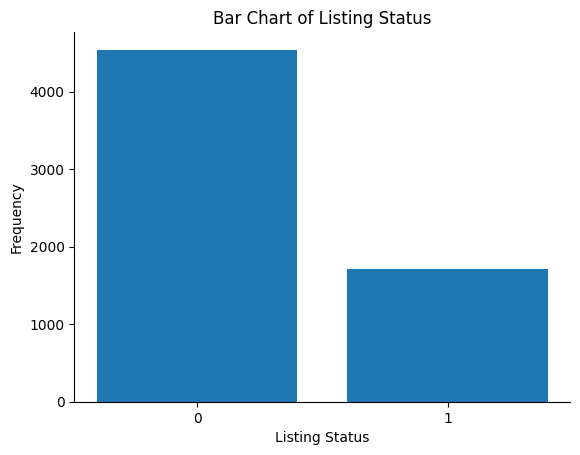

In [223]:
plt.bar(
    df_clean["unlisted"].value_counts().index,
    df_clean["unlisted"].value_counts().values,
)
plt.grid(False)
plt.title("Bar Chart of Listing Status")
plt.xlabel("Listing Status")
plt.ylabel("Frequency")
plt.xticks(np.arange(0,2))
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.show()

### Description

In [224]:
# Get size of description and order by biggest to smallest
df_clean["description"].apply(len).value_counts()

description
659    57
649    49
662    49
683    45
661    43
       ..
267     1
405     1
17      1
171     1
446     1
Name: count, Length: 751, dtype: int64

In [225]:
# Get Description word count and order by biggest to smallest
df_clean["description_word_count"] = df_clean["description"].apply(
    lambda x: len(str(x).split(" "))
)
df_clean["description_word_count"].value_counts()

description_word_count
93     240
91     235
95     223
96     222
94     219
      ... 
135      1
125      1
136      1
128      1
142      1
Name: count, Length: 133, dtype: int64

In [227]:
df_clean[df_clean["description_word_count"] == 3]["description"]

746            license number exempt
1299    license number 9996004475162
1353           license number exempt
1743          license number 80766al
1833           license number exempt
1869           license number exempt
1875           license number exempt
1878           license number exempt
1944              bedroom double bed
2469                 quiet nice room
2500           license number exempt
2688           license number exempt
3147              license number 668
3647           license number exempt
3977           license number exempt
4380           license number exempt
4606           license number exempt
4970           license number exempt
5008           license number at6911
5102           license number exempt
5163           license number exempt
5243           license number exempt
5606           license number exempt
5751           license number exempt
6245           license number exempt
Name: description, dtype: object

In [228]:
df_clean["description_word_count"].describe()

count    6248.000000
mean       77.368918
std        27.156975
min         2.000000
25%        60.000000
50%        89.000000
75%        96.000000
max       162.000000
Name: description_word_count, dtype: float64

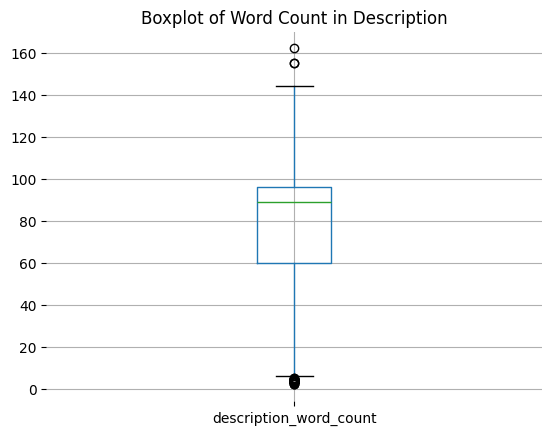

In [229]:
df_clean.boxplot(column=["description_word_count"])
plt.title("Boxplot of Word Count in Description")
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["bottom"].set_visible(False)
plt.gca().spines["left"].set_visible(False)
plt.show()

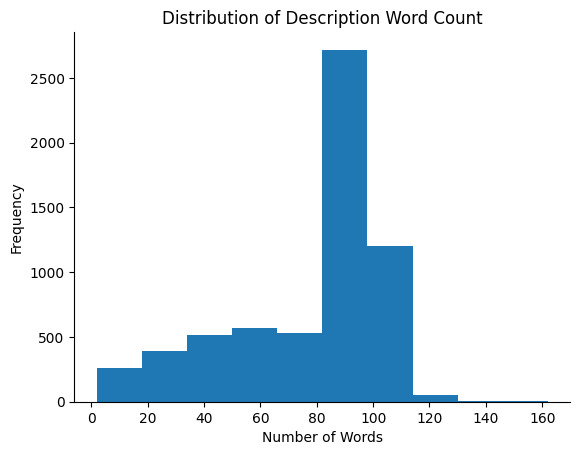

In [230]:
df_clean["description_word_count"].hist()
plt.grid(False)
plt.title("Distribution of Description Word Count")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.show()

> These plots give us visually the information we already had on the previous cell with the `.describe()` method.

##### Most Frequent Words in Description

In [231]:
all_words = " ".join(df_clean["description"].str.lower()).split()

freq = pd.Series(all_words).value_counts()

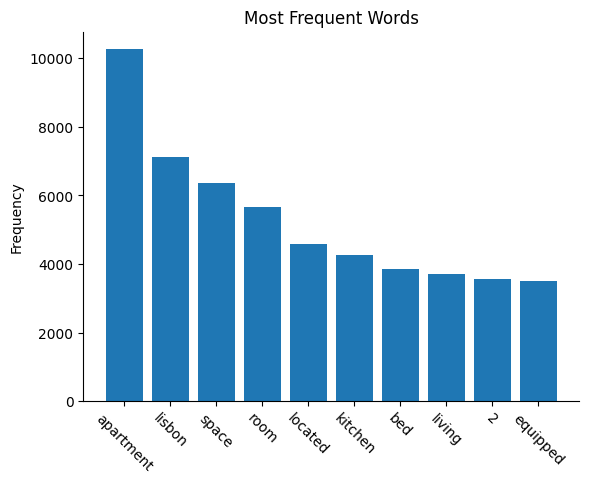

In [236]:
x_labels = freq.index[0:10]
values = freq[:10]
plt.bar(x_labels, values)
plt.xticks(x_labels, rotation = -45)
plt.ylabel("Frequency")
plt.title("Most Frequent Words")
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.show()

### Comments

To explore comments, we will first see how many empty comment rows we have.

In [237]:
df_clean["comments"].isna().sum()

0

In [238]:
comment_counts = df_clean.groupby("listing_id")["comments"].count()

# Sort the counts in descending order
sorted_comment_counts = comment_counts.sort_values(ascending=False)

# Display the top 10 indices with the most comments
top_10_indices = sorted_comment_counts.head(10)
top_10_indices

listing_id
1       1
4150    1
4172    1
4171    1
4170    1
4169    1
4168    1
4167    1
4166    1
4165    1
Name: comments, dtype: int64

In [239]:
# get character count of comments
df_clean["comment_character_count"] = df_train_lm["comments"].apply(len)

df_clean["comment_character_count"].value_counts()

comment_character_count
12       2003
875         4
65          4
2654        4
57          4
         ... 
580         1
59877       1
487         1
28109       1
23528       1
Name: count, Length: 3848, dtype: int64

In [240]:
df_clean[df_clean["comment_character_count"] == 3]["comments"].value_counts()

Series([], Name: count, dtype: int64)

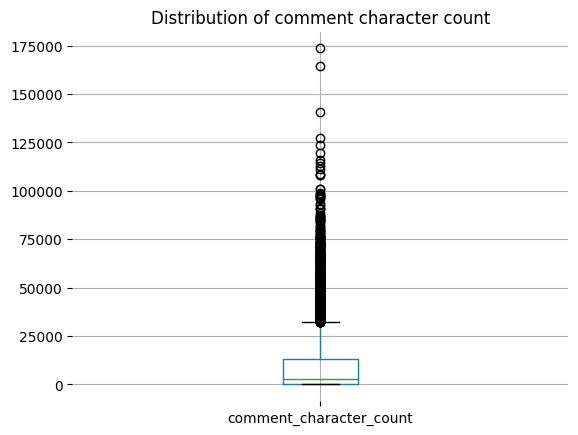

In [241]:
df_clean.boxplot(column=["comment_character_count"])
plt.title("Distribution of comment character count")
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["bottom"].set_visible(False)
plt.gca().spines["left"].set_visible(False)
plt.show()

In [249]:
# get word count of comments
df_clean["comment_word_count"] = df_clean["comments"].apply(lambda x: len(str(x).split(" ")))

df_clean["comment_word_count"].value_counts()

comment_word_count
2       2006
15        10
41         9
27         9
8          8
        ... 
567        1
2527       1
2663       1
5256       1
6046       1
Name: count, Length: 2644, dtype: int64

In [251]:
# Even 1-worded comments seem valid (apart from non-alphabetical ones, obviously)
df_clean[df_clean["comment_word_count"] == 1]["comments"][:]

4583    mantra
Name: comments, dtype: object

The preprocessing significantly reduced the number of 1 word comments existing. We only find 1. This is because our dataset is now merged.

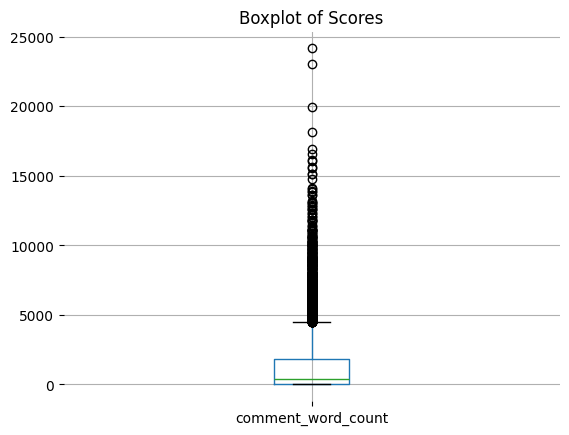

In [252]:
df_clean.boxplot(column=["comment_word_count"])
plt.title("Boxplot of Scores")
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["bottom"].set_visible(False)
plt.gca().spines["left"].set_visible(False)
plt.show()

In [253]:
all_comment_words = " ".join(df_clean["comments"].str.lower()).split()

freq = pd.Series(all_comment_words).value_counts().sort_values(ascending=False)

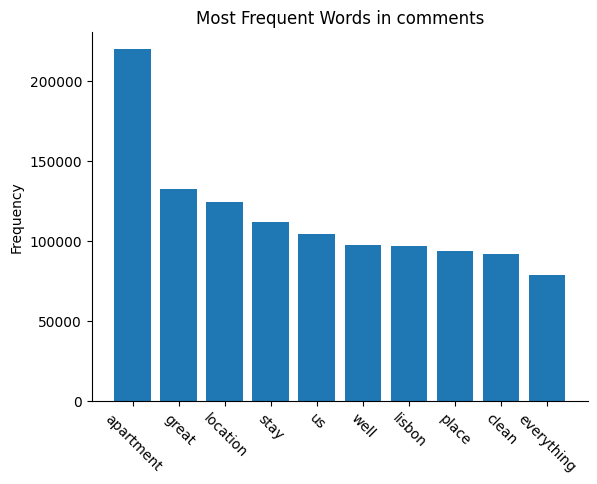

In [255]:
x_labels = freq.index[0:10]
values = freq[:10]
plt.bar(x_labels, values)
plt.xticks(x_labels, rotation = -45)
plt.ylabel("Frequency")
plt.title("Most Frequent Words in comments")
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.show()

In [256]:
# check for duplicated columns by 'listing_id' and 'comments', and show rows
duplicated_rows = df_clean[df_clean.duplicated(["listing_id", "comments"])]

duplicated_rows[["listing_id", "comments", "comment_word_count"]].sort_values("comment_word_count", ascending=False)[:10]

Empty DataFrame
Columns: [listing_id, comments, comment_word_count]
Index: []

With preprocessing, we got rid of duplicates.

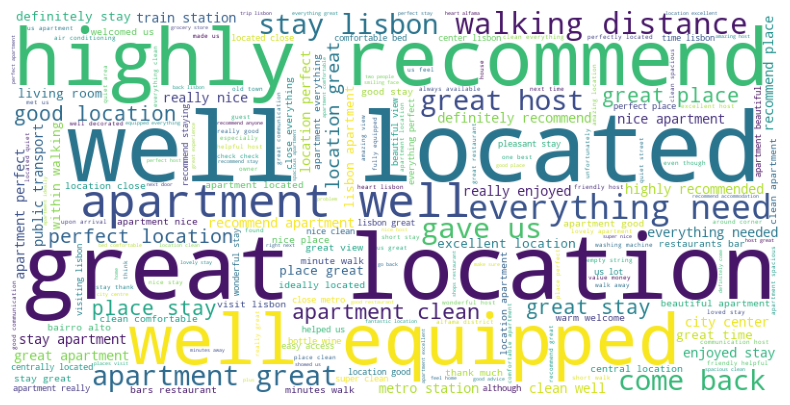

In [258]:
# Joining all the comments into a single string
all_reviews = " ".join(df_clean["comments"])

# Create WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(all_reviews)

# Plotting the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud)
plt.axis("off")
plt.show();

### Host_about

In [260]:
# Get character size of host_about
df_clean["host_about_character_count"] = df_clean["host_about"].apply(len)

df_clean["host_about_character_count"].value_counts()

host_about_character_count
495     155
447      93
0        81
289      72
396      71
       ... 
1257      1
568       1
743       1
813       1
815       1
Name: count, Length: 679, dtype: int64

In [261]:
df_clean[df_clean["host_about_character_count"] == 6]["host_about"]

32      suites
514     alfama
2287    lisboa
2481    alfama
2666    simple
2774    simple
2887    canada
2987    lugano
3062    rachel
5421    morena
Name: host_about, dtype: object

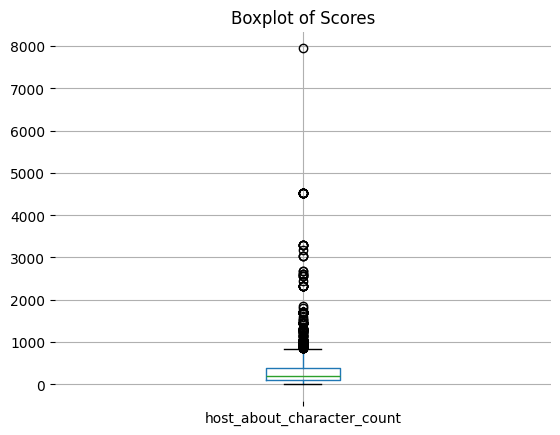

In [262]:
df_clean.boxplot(column=["host_about_character_count"])
plt.title("Boxplot of Scores")
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["bottom"].set_visible(False)
plt.gca().spines["left"].set_visible(False)
plt.show()

We decided not to show a bar plot of the `host_about_character_count` as there are many outliers (as seen above) and it would make the plot unreadable.

In [263]:
df_clean["host_about_word_count"] = df_clean["host_about"].apply(lambda x: len(str(x).split(" ")))

df_clean["host_about_word_count"].value_counts()

host_about_word_count
67     190
5      167
20     152
2      149
1      143
      ... 
125      1
144      1
185      1
166      1
122      1
Name: count, Length: 169, dtype: int64

In [264]:
# I think it's ok to say even from 1-worded host_about, it's still valid (apart from non-alphabetical ones, obviously)
df_clean[df_clean["host_about_word_count"] == 1]["host_about"]

18                   
32             suites
85                   
92                   
110                  
            ...      
5985                 
6011     entrepreneur
6156            funny
6159            happy
6191    perfectionist
Name: host_about, Length: 143, dtype: object

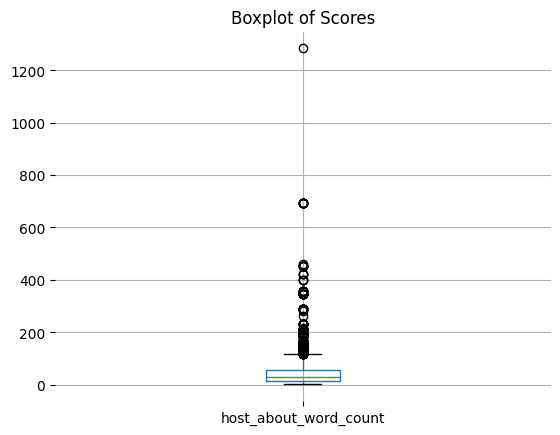

In [265]:
df_clean.boxplot(column=["host_about_word_count"])
plt.title("Boxplot of Scores")
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["bottom"].set_visible(False)
plt.gca().spines["left"].set_visible(False)
plt.show()

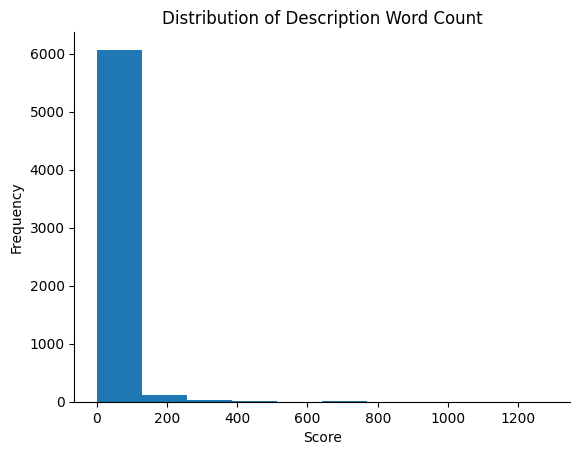

In [266]:
df_clean["host_about_word_count"].hist()
plt.grid(False)
plt.title("Distribution of Description Word Count")
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.show()

In [267]:
all_words = " ".join(df_clean["host_about"].str.lower()).split()

freq = pd.Series(all_words).value_counts()

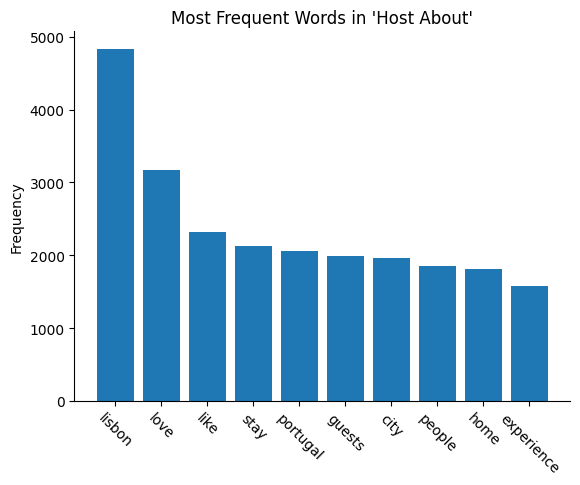

In [269]:
x_labels = freq.index[0:10]
values = freq[:10]
plt.bar(x_labels, values)
plt.xticks(x_labels, rotation = -45)
plt.ylabel("Frequency")
plt.title("Most Frequent Words in 'Host About'")
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.show()

Checking for duplicated `host_about` descriptions are unnecessary as hosts may have more than 1 listing.

# Feature Engineering

### Train-Test Split for **Lemmatized** data

##### **Note**: Although the train-test split is usually the first thing to be done, in our case we did not apply any methods to the data that would lead to data leakage. Therefore, it is fine to apply the train_test_split after the rest of the data preprocessing

In [270]:
df_train_lm = pd.read_csv("train_clean_merged_lm.csv")

In [272]:
X_data = df_train_lm.drop(columns=["unlisted"])
y_data = df_train_lm["unlisted"]
df_train, df_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.3, stratify=y_data, random_state=42)

In [273]:
df_train["unlisted"] = y_train
df_test["unlisted"] = y_test

In [274]:
# check proportion of unlisted after spliting
df_train["unlisted"].value_counts(normalize=True)

unlisted
0    0.726732
1    0.273268
Name: proportion, dtype: float64

Proportion holds after splitting.

In [275]:
df_train.to_csv("df_train_split_lm.csv", index = False)
df_test.to_csv("df_test_split_lm.csv", index = False)

### Train-Test Split for **Stemmed** data

In [276]:
df_train_stm = pd.read_csv("train_clean_merged_stm.csv")

In [278]:
X_data = df_train_stm.drop(columns=["unlisted"])
y_data = df_train_stm["unlisted"]
df_train, df_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.3, stratify=y_data, random_state=42)

In [279]:
df_train["unlisted"] = y_train
df_test["unlisted"] = y_test

In [280]:
# check proportion of unlisted after spliting
df_train["unlisted"].value_counts(normalize=True)

unlisted
0    0.726732
1    0.273268
Name: proportion, dtype: float64

Proportion holds after splitting.

In [281]:
df_train.to_csv("df_train_split_stm.csv", index = False)
df_test.to_csv("df_test_split_stm.csv", index = False)

### Word2Vec Implementation (with lemmatized data)

#### Corpus definition

In [282]:
df_train = pd.read_csv("train_clean_merged_lm.csv")

In [284]:
def sentence_to_wordlist(raw):
    words = word_tokenize(raw)  # Tokenize words in each sentence
    return words

# Tokenize each comment into sentences, then words, and flatten into a single list
corpus = [sentence_to_wordlist(sentence) for comment in df_train['comments'] for sentence in sent_tokenize(comment)]

In [285]:
loss_list = []
loss_list.append(0)

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

class Callback(CallbackAny2Vec):
    def __init__(self):
        self.epoch = 0

        def on_epoch_end(self, model):
            loss = model.get_latest_training_loss()
            now_loss = loss - loss_list[-1]
            loss_list.append(loss)
            print(f"Loss after epoch {self.epoch}: {now_loss}")
            self.epoch = self.epoch + 1

In [286]:
w2v = Word2Vec(corpus, min_count = 10, vector_size = 400, sg = 1, compute_loss = True, workers = 4, seed = 42, epochs = 500,  callbacks=[Callback()]) 

2024-06-09 09:26:25,660 : INFO : collecting all words and their counts
2024-06-09 09:26:25,661 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2024-06-09 09:26:27,263 : INFO : collected 52537 word types from a corpus of 9613750 raw words and 6248 sentences
2024-06-09 09:26:27,264 : INFO : Creating a fresh vocabulary
2024-06-09 09:26:27,318 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=10 retains 11056 unique words (21.04% of original 52537, drops 41481)', 'datetime': '2024-06-09T09:26:27.318597', 'gensim': '4.3.2', 'python': '3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19045-SP0', 'event': 'prepare_vocab'}
2024-06-09 09:26:27,319 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=10 leaves 9529373 word corpus (99.12% of original 9613750, drops 84377)', 'datetime': '2024-06-09T09:26:27.319596', 'gensim': '4.3.2', 'python': '3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 

In [287]:
# Saving the model
with tempfile.NamedTemporaryFile(prefix='gensim-model-', delete=False) as tmp:
    temporary_filepath = tmp.name
    w2v.save(temporary_filepath)

2024-06-09 14:54:41,789 : INFO : Word2Vec lifecycle event {'fname_or_handle': 'C:\\Users\\andre\\AppData\\Local\\Temp\\gensim-model-ppdvibb5', 'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(), 'datetime': '2024-06-09T14:54:41.789019', 'gensim': '4.3.2', 'python': '3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19045-SP0', 'event': 'saving'}
2024-06-09 14:54:41,792 : INFO : not storing attribute cum_table
2024-06-09 14:54:42,528 : INFO : saved C:\Users\andre\AppData\Local\Temp\gensim-model-ppdvibb5


In [288]:
# # Load model
# w2v = gensim.models.Word2Vec.load('C:\\Users\\andre\\OneDrive\\Documentos\\Nova IMS\\1º ano\\2º Semestre\\Text Mining\\Project\\Project Corpora\\w2v_model_final')

In [289]:
# Auxiliary function

def reduce_dimensions(model):
    num_dimensions = 2  # final num dimensions (2D, 3D, etc)

    # extract the words & their vectors, as numpy arrays
    vectors = np.asarray(model.wv.vectors)
    labels = np.asarray(model.wv.index_to_key)  # fixed-width numpy strings

   # # Convert numpy strings to standard Python strings (maybe not needed)
    #labels = [str(label) for label in labels]

    # reduce using t-SNE
    tsne = TSNE(n_components=num_dimensions, random_state=42)
    vectors = tsne.fit_transform(vectors)

    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    return x_vals, y_vals, labels

In [290]:
# Auxiliary function

def plot_with_plotly(x_vals, y_vals, labels, plot_in_notebook=True):
    from plotly.offline import init_notebook_mode, iplot, plot
    import plotly.graph_objs as go

    # Define the trace
    trace = go.Scatter(x=x_vals, y=y_vals, mode='markers', text=labels, hoverinfo='text')
    data = [trace]
    
    # Define the layout
    layout = go.Layout(
        title='Hover over points to see labels',
        xaxis=dict(title='X Axis Label'),
        yaxis=dict(title='Y Axis Label'),
        hovermode='closest'  # Ensures the hover is for the closest point
    )

    # Create a figure with data and layout
    fig = go.Figure(data=data, layout=layout)

    # Plot in notebook or create HTML file
    if plot_in_notebook:
        init_notebook_mode(connected=True)
        iplot(fig)
    else:
        plot(fig, filename='plot.html')  # Outputs an HTML file with the plot

In [291]:
x_vals, y_vals, labels = reduce_dimensions(w2v)

In [292]:
plot_with_plotly(x_vals, y_vals, labels, plot_in_notebook=True)

### Implementing Transformer: Roberta - `j-hartmann/emotion-english-roberta-large`: https://huggingface.co/j-hartmann/emotion-english-roberta-large

**Note**: Since this engineering method is only implemented to guarantee the 4 implementations necessary for the project requirements, we will work with the whole dataset (without train_test split). We will not use this method in later stages.

In [293]:
# Using lemmatized dataset
df_train = pd.read_csv("train_clean_merged_lm.csv")

In [ ]:
notebook_login()

In [298]:
def get_embeddings_roberta(dataframe:pd.DataFrame, model_name:str="j-hartmann/emotion-english-roberta-large", max_length:int=512):
    
    copy_df = dataframe.copy()
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    tokenizer = AutoTokenizer.from_pretrained(model_name)

    model = AutoModel.from_pretrained(model_name).to(device)

    def get_actual_embeddings(text,model_obj, tokenizer_obj, max_length=512):

        inputs = tokenizer_obj(text, return_tensors="pt", truncation=True, padding=True, max_length=max_length).to(device)
        outputs = model_obj(**inputs)
        mean_embeddings = outputs.last_hidden_state.mean(dim=1).detach().cpu().numpy()
        
        return mean_embeddings
    
    mean_embeddings_dict = {}
    
    # use tqdm to know how much time left
    for row_index, row in tqdm(copy_df.iterrows(), total=len(copy_df)):
        listing_id = row["listing_id"]
        comment = str(row["comments"])
        unlisted = row["unlisted"]
        mean_embeddings = get_actual_embeddings(comment, model, tokenizer, max_length)
        mean_embeddings_dict[listing_id] = {"embeddings":mean_embeddings, "target":unlisted}
    # save the embeddings on a column

    return mean_embeddings_dict

In [ ]:
# train set
train_embeddings_roberta = get_embeddings_roberta(df_train, model_name="j-hartmann/emotion-english-roberta-large", max_length=512)

# test set
test_embeddings_roberta = get_embeddings_roberta(df_test, model_name="j-hartmann/emotion-english-roberta-large", max_length=512)


# prepare embeddings for models
train_embeddings_roberta_models = np.array([train_embeddings_roberta[key]["embeddings"] for key in train_embeddings_roberta.keys()])
train_embeddings_roberta_models = train_embeddings_roberta_models.reshape(train_embeddings_roberta_models.shape[0], train_embeddings_roberta_models.shape[2])

# target for sklearn
target_embeddings_roberta_models = np.array([test_embeddings_roberta[key]["target"] for key in test_embeddings_roberta.keys()])
target_embeddings_roberta_models = target_embeddings_roberta_models.reshape(-1,1)

In [ ]:
train_embeddings_roberta.shape, test_embeddings_roberta.shape, train_embeddings_roberta_models.shape, target_embeddings_roberta_models.shape

##### Performing one experiment only with this transformer

In [ ]:
lr_roberta_model = LogisticRegression(class_weight="balanced", random_state=42, n_jobs=-1)

lr_roberta_model.fit(train_embeddings_roberta_models, target_embeddings_roberta_models)

# Evaluate
lr_roberta_model_predictions = lr_roberta_model.predict(test_embeddings_roberta)

In [ ]:
# Classification report
lr_robert_model_report = classification_report(test_embeddings_roberta, lr_roberta_model_predictions, target_names=["listed", "unlisted"])

print("LOGISTIC REGRESSION WITH EMBEDDINGS (MEAN BERT) REPORT\n \n")

print(lr_robert_model_report)

plot_conf_matrix(test_embeddings_roberta, lr_roberta_model_predictions, labels=["Not Unlisted", "Unlisted"], plot_name="Lemmatized Roberta Logistic Regression Confusion Matrix")

### From this part onwards, as the project requirements expect us to experiment different combinations of preprocessing, engineering, and classification methods, the notebook will branch out into 3 parts.

> ##### Part 1: Lemmatization + TF-IDF + Classification (All models)
> ##### Part 2: Lemmatization + GloVe + Classification (All models)
> ##### Part 3: Stemming + Transformer (BERT) + Classification (All models)
> ##### Part 4: Evaluation: Choose best model out of all combinations based on F1 score, and apply to test set for predictions.

# Part 1: Lemmatization + TF-IDF + Classification (All models)

# TF-IDF

In [36]:
df_train = pd.read_csv("df_train_split_lm.csv")
df_test = pd.read_csv("df_test_split_lm.csv")

In [37]:
tf_idf = TfidfVectorizer(max_features=15000,smooth_idf=True, stop_words="english", sublinear_tf=True)

In [38]:
X_data_train, y_data_train = tf_idf.fit_transform(df_train["comments"]), df_train["unlisted"]

X_data_test, y_data_test = tf_idf.transform(df_test["comments"]), df_test["unlisted"]

In [39]:
X_data_train.shape, X_data_test.shape, y_data_train.shape, y_data_test.shape

((4373, 15000), (1875, 15000), (4373,), (1875,))

# Models


 
 Lemmatized TF-IDF Logistic Regression Classifier 
 

              precision    recall  f1-score   support

           0       0.94      0.87      0.90      1362
           1       0.70      0.85      0.77       513

    accuracy                           0.86      1875
   macro avg       0.82      0.86      0.83      1875
weighted avg       0.87      0.86      0.86      1875


 



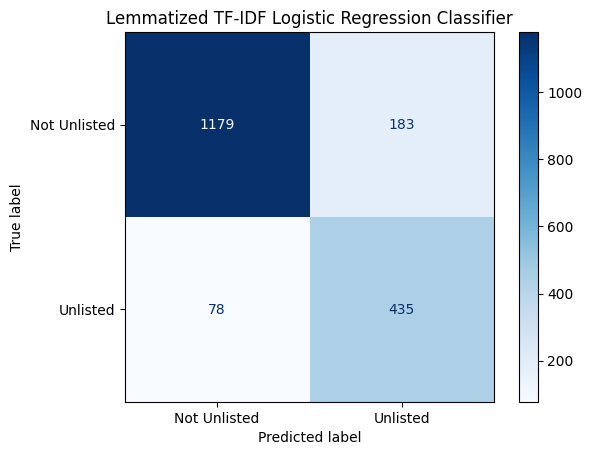

In [8]:
# Logistic Regression

lr = LogisticRegression(class_weight="balanced", random_state=42, n_jobs=-1)

lr.fit(X_data_train, y_data_train)

predictions_lr = lr.predict(X_data_test)

lr_classif_report = classification_report(y_data_test, predictions_lr)


print("\n \n Lemmatized TF-IDF Logistic Regression Classifier \n \n")

print(lr_classif_report)

print("\n \n")

plot_conf_matrix(y_data_test, predictions_lr, labels=["Not Unlisted", "Unlisted"], plot_name="Lemmatized TF-IDF Logistic Regression Classifier")


 
 Lemmatized TF-IDF KNN Classifier 
 

              precision    recall  f1-score   support

           0       0.73      1.00      0.84      1362
           1       0.60      0.01      0.01       513

    accuracy                           0.73      1875
   macro avg       0.66      0.50      0.43      1875
weighted avg       0.69      0.73      0.61      1875


 



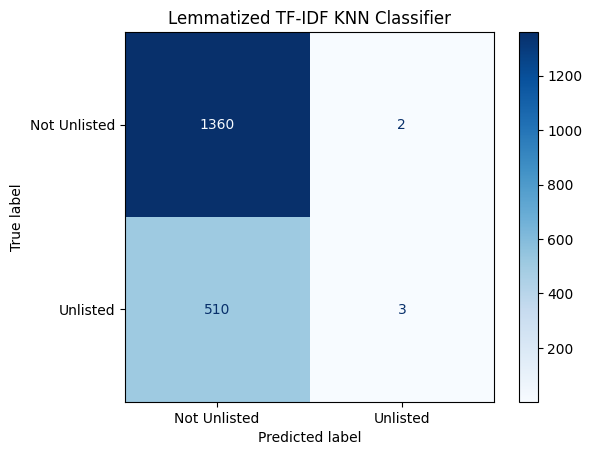

In [9]:
# K-Nearest Neighbors

knn = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)

knn.fit(X_data_train, y_data_train)

predictions_knn = knn.predict(X_data_test)

knn_classif_report = classification_report(y_data_test, predictions_knn)


print("\n \n Lemmatized TF-IDF KNN Classifier \n \n")

print(knn_classif_report)

print("\n \n")

plot_conf_matrix(y_data_test, predictions_knn, labels=["Not Unlisted", "Unlisted"], plot_name="Lemmatized TF-IDF KNN Classifier")

-- Epoch 1
Norm: 0.00, NNZs: 14976, Bias: 0.000000, T: 3935, Avg. loss: 0.999796
Total training time: 0.04 seconds.
-- Epoch 2
Norm: 0.00, NNZs: 14976, Bias: 0.000000, T: 7870, Avg. loss: 0.999386
Total training time: 0.05 seconds.
-- Epoch 3
Norm: 0.00, NNZs: 14976, Bias: 0.000000, T: 11805, Avg. loss: 0.998980
Total training time: 0.06 seconds.
-- Epoch 4
Norm: 0.01, NNZs: 14976, Bias: 0.000000, T: 15740, Avg. loss: 0.998575
Total training time: 0.07 seconds.
-- Epoch 5
Norm: 0.01, NNZs: 14976, Bias: 0.000000, T: 19675, Avg. loss: 0.998167
Total training time: 0.08 seconds.
-- Epoch 6
Norm: 0.01, NNZs: 14976, Bias: 0.000000, T: 23610, Avg. loss: 0.997759
Total training time: 0.08 seconds.
Convergence after 6 epochs took 0.09 seconds

 
 Lemmatized TF-IDF SGD Classifier 
 

              precision    recall  f1-score   support

           0       0.94      0.87      0.90      1362
           1       0.70      0.85      0.77       513

    accuracy                           0.86      1

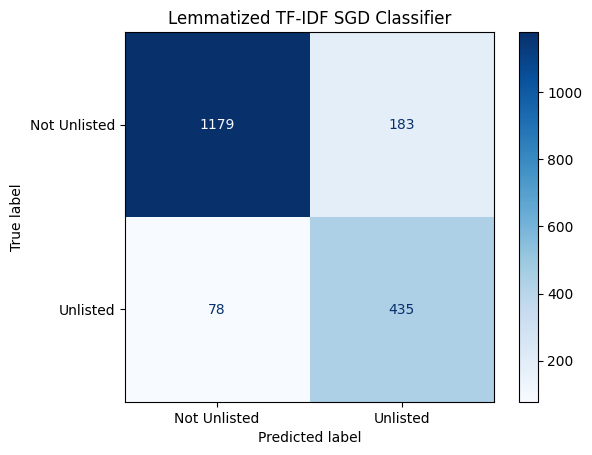

In [10]:
# Stochastic Gradient Descent

sgd = SGDClassifier(loss="hinge", penalty="l2", max_iter=1000, class_weight="balanced",\
     random_state=42, fit_intercept=False, tol=0.001, early_stopping=True, validation_fraction=0.1, \
        n_iter_no_change=5, n_jobs=-1, verbose=1, shuffle=True, learning_rate="adaptive", eta0=0.000001)

sgd.fit(X_data_train, y_data_train)

predictions_sgd = sgd.predict(X_data_test)

sgd_classif_report = classification_report(y_data_test, predictions_sgd)

In [ ]:
print("\n \n Lemmatized TF-IDF SGD Classifier \n \n")

print(sgd_classif_report)

print("\n \n")

plot_conf_matrix(y_data_test, predictions_sgd, labels=["Not Unlisted", "Unlisted"], plot_name="Lemmatized TF-IDF SGD Classifier")


 
 Lemmatized TF-IDF MLP Classifier 
 

              precision    recall  f1-score   support

           0       0.94      0.86      0.90      1362
           1       0.70      0.86      0.77       513

    accuracy                           0.86      1875
   macro avg       0.82      0.86      0.84      1875
weighted avg       0.88      0.86      0.87      1875


 



c:\Users\andre\OneDrive\Documentos\Nova IMS\1º ano\2º Semestre\Text Mining\tm_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


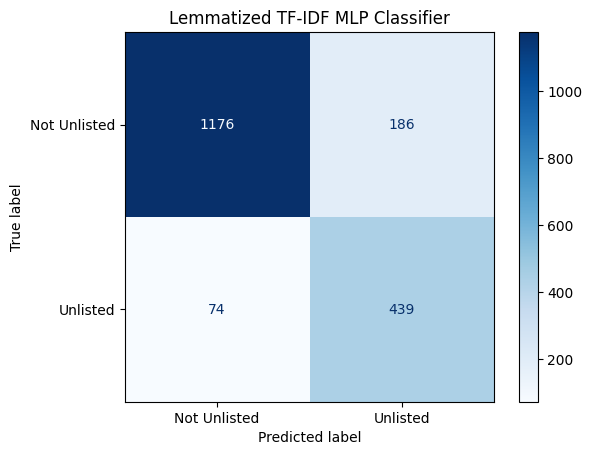

In [40]:
# Multi-Layer Perceptron (MLP)

mlp = MLPClassifier(solver='adam', hidden_layer_sizes=(2,2), activation='logistic', random_state=42)

mlp.fit(X_data_train, y_data_train)

predictions_mlp = mlp.predict(X_data_test)

mlp_classif_report = classification_report(y_data_test, predictions_mlp)


print("\n \n Lemmatized TF-IDF MLP Classifier \n \n")

print(mlp_classif_report)

print("\n \n")

plot_conf_matrix(y_data_test, predictions_mlp, labels=["Not Unlisted", "Unlisted"], plot_name="Lemmatized TF-IDF MLP Classifier")

#### Other Advanced Models - Random Forest and HistGradientBoosting

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.2s finished



 
 Lemmatized TF-IDF Random Forest Classifier 
 

              precision    recall  f1-score   support

           0       0.94      0.87      0.90      1362
           1       0.70      0.85      0.77       513

    accuracy                           0.86      1875
   macro avg       0.82      0.86      0.83      1875
weighted avg       0.87      0.86      0.86      1875


 



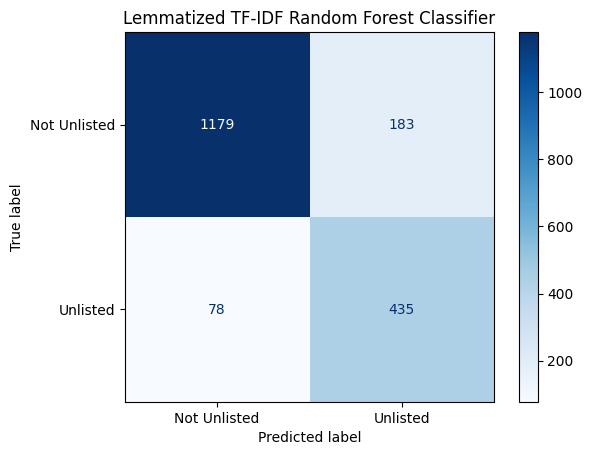

In [12]:
# Random Forest

rf_classifier = RandomForestClassifier(random_state=42, n_jobs=-1, class_weight="balanced", verbose=1)

rf_classifier.fit(X_data_train, y_data_train)

predictions_rf = rf_classifier.predict(X_data_test)

rf_classif_report = classification_report(y_data_test, predictions_rf)


print("\n \n Lemmatized TF-IDF Random Forest Classifier \n \n")

print(rf_classif_report)

print("\n \n")

plot_conf_matrix(y_data_test, predictions_rf, labels=["Not Unlisted", "Unlisted"], plot_name="Lemmatized TF-IDF Random Forest Classifier")

Binning 0.525 GB of training data: 5.981 s
Fitting gradient boosted rounds:
[1/100] 1 tree, 31 leaves, max depth = 13, in 1.273s
[2/100] 1 tree, 31 leaves, max depth = 12, in 2.238s
[3/100] 1 tree, 31 leaves, max depth = 16, in 1.405s
[4/100] 1 tree, 31 leaves, max depth = 17, in 2.298s
[5/100] 1 tree, 31 leaves, max depth = 15, in 1.645s
[6/100] 1 tree, 31 leaves, max depth = 11, in 1.991s
[7/100] 1 tree, 31 leaves, max depth = 14, in 1.286s
[8/100] 1 tree, 31 leaves, max depth = 15, in 1.573s
[9/100] 1 tree, 31 leaves, max depth = 14, in 2.052s
[10/100] 1 tree, 31 leaves, max depth = 16, in 1.344s
[11/100] 1 tree, 31 leaves, max depth = 15, in 2.246s
[12/100] 1 tree, 31 leaves, max depth = 16, in 1.412s
[13/100] 1 tree, 31 leaves, max depth = 17, in 2.366s
[14/100] 1 tree, 31 leaves, max depth = 13, in 1.326s
[15/100] 1 tree, 31 leaves, max depth = 15, in 2.361s
[16/100] 1 tree, 31 leaves, max depth = 20, in 1.502s
[17/100] 1 tree, 31 leaves, max depth = 11, in 2.457s
[18/100] 1 tree

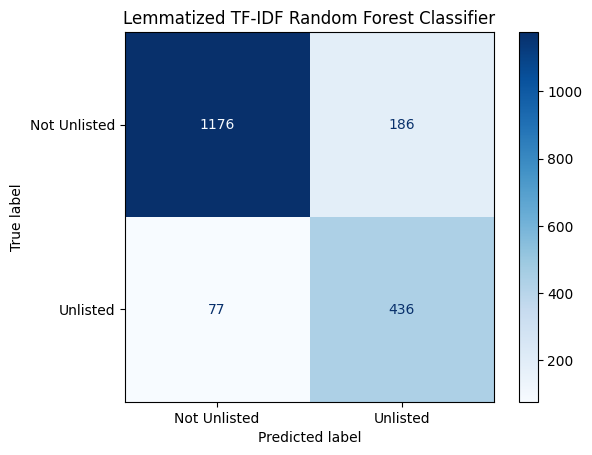

In [13]:
# HistGradientBoosting

hist_grad_boost = HistGradientBoostingClassifier(random_state=42, verbose=1)

hist_grad_boost.fit(X_data_train.toarray(), y_data_train)

predictions_histgradboost = hist_grad_boost.predict(X_data_test.toarray())

histgradboost_classif_report = classification_report(y_data_test, predictions_histgradboost)

In [ ]:
print("\n \n Lemmatized TF-IDF HistGradientBoosting Classifier \n \n")

print(histgradboost_classif_report)

print("\n \n")

plot_conf_matrix(y_data_test, predictions_histgradboost, labels=["Not Unlisted", "Unlisted"], plot_name="Lemmatized TF-IDF Random Forest Classifier")

# Part 2: Lemmatization + GloVe + Classification (All models)

# GloVe

In [14]:
df_train = pd.read_csv("df_train_split_lm.csv")
df_test = pd.read_csv("df_test_split_lm.csv")

In [15]:
glove = vocab.GloVe(name='840B', dim=300)
print(f'Loaded {len(glove.itos)} words')

Loaded 2196017 words


In [16]:
def from_sentence_to_vec_840B(sentence_to_vectorize):
    sentence_vec = []
    for word in sentence_to_vectorize:
        try:
            word_vec = glove.get_vecs_by_tokens(word, lower_case_backup=True)
            sentence_vec.append(word_vec)
        except KeyError:
            pass
    sentence_mean = np.mean(sentence_vec, axis=0)
    return sentence_mean

In [17]:
train_comments_list = df_train["comments"].tolist()
train_comments_list = [sentence.split() for sentence in train_comments_list]

test_comments_list = df_test["comments"].tolist()
test_comments_list = [sentence.split() for sentence in test_comments_list]

In [18]:
sentence_vecs_train = []
sentence_vecs_test = []

# train
for i in tqdm(range(len(train_comments_list))):
    sentence_vec = from_sentence_to_vec_840B(train_comments_list[i])
    sentence_vecs_train.append(sentence_vec)

# test
for i in tqdm(range(len(test_comments_list))):
    sentence_vec = from_sentence_to_vec_840B(test_comments_list[i])
    sentence_vecs_test.append(sentence_vec)

100%|██████████| 1875/1875 [01:05<00:00, 28.46it/s]


In [19]:
sentence_vecs_train = torch.tensor(sentence_vecs_train)
sentence_vecs_test = torch.tensor(sentence_vecs_test)

target_train = torch.tensor(df_train["unlisted"].tolist())
target_test = torch.tensor(df_test["unlisted"].tolist())

C:\Users\andre\AppData\Local\Temp\ipykernel_13528\754445955.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:277.)
  sentence_vecs_train = torch.tensor(sentence_vecs_train)


# Models


 
 Stemmed GloVe Logistic Regression Classifier 
 

              precision    recall  f1-score   support

           0       0.94      0.86      0.90      1362
           1       0.70      0.85      0.77       513

    accuracy                           0.86      1875
   macro avg       0.82      0.86      0.83      1875
weighted avg       0.87      0.86      0.86      1875


 



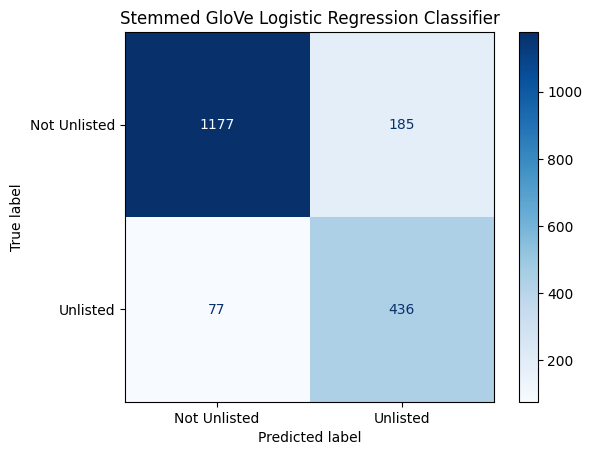

In [20]:
# Logistic Regression

lr = LogisticRegression(class_weight="balanced", random_state=42, n_jobs=-1)

lr.fit(sentence_vecs_train, target_train)

predictions_lr = lr.predict(sentence_vecs_test)

lr_classif_report = classification_report(target_test, predictions_lr)


print("\n \n Lemmatized GloVe Logistic Regression Classifier \n \n")

print(lr_classif_report)

print("\n \n")

plot_conf_matrix(target_test, predictions_lr, labels=["Not Unlisted", "Unlisted"], plot_name="Lemmatized GloVe Logistic Regression Classifier")



 
 Stemmed GloVe KNN Classifier 
 

              precision    recall  f1-score   support

           0       0.94      0.86      0.90      1362
           1       0.70      0.85      0.77       513

    accuracy                           0.86      1875
   macro avg       0.82      0.86      0.83      1875
weighted avg       0.87      0.86      0.86      1875


 



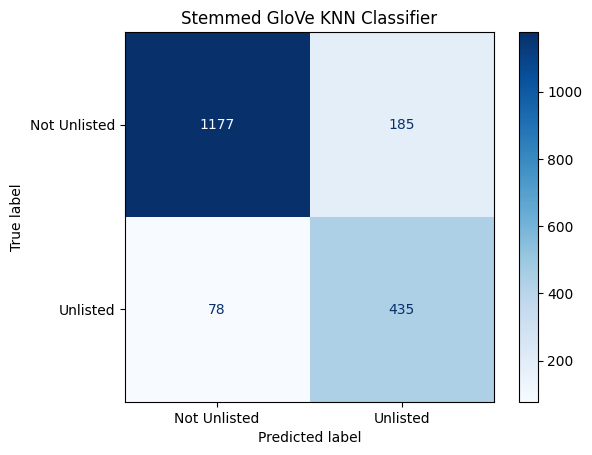

In [21]:
# K-Nearest Neighbors

knn = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)

knn.fit(sentence_vecs_train, target_train)

predictions_knn = knn.predict(sentence_vecs_test)

knn_classif_report = classification_report(target_test, predictions_knn)


print("\n \n Lemmatized GloVe KNN Classifier \n \n")

print(knn_classif_report)

print("\n \n")

plot_conf_matrix(target_test, predictions_knn, labels=["Not Unlisted", "Unlisted"], plot_name="Lemmatized GloVe KNN Classifier")

-- Epoch 1
Norm: 0.01, NNZs: 300, Bias: 0.000000, T: 3935, Avg. loss: 0.996975
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 0.01, NNZs: 300, Bias: 0.000000, T: 7870, Avg. loss: 0.991037
Total training time: 0.01 seconds.
-- Epoch 3
Norm: 0.02, NNZs: 300, Bias: 0.000000, T: 11805, Avg. loss: 0.985401
Total training time: 0.01 seconds.
-- Epoch 4
Norm: 0.03, NNZs: 300, Bias: 0.000000, T: 15740, Avg. loss: 0.979628
Total training time: 0.02 seconds.
-- Epoch 5
Norm: 0.04, NNZs: 300, Bias: 0.000000, T: 19675, Avg. loss: 0.973619
Total training time: 0.02 seconds.
-- Epoch 6
Norm: 0.04, NNZs: 300, Bias: 0.000000, T: 23610, Avg. loss: 0.967779
Total training time: 0.03 seconds.
Convergence after 6 epochs took 0.03 seconds

 
 Stemmed GloVe SGD Classifier 
 

              precision    recall  f1-score   support

           0       0.94      0.86      0.90      1362
           1       0.70      0.85      0.77       513

    accuracy                           0.86      1875
   macro avg

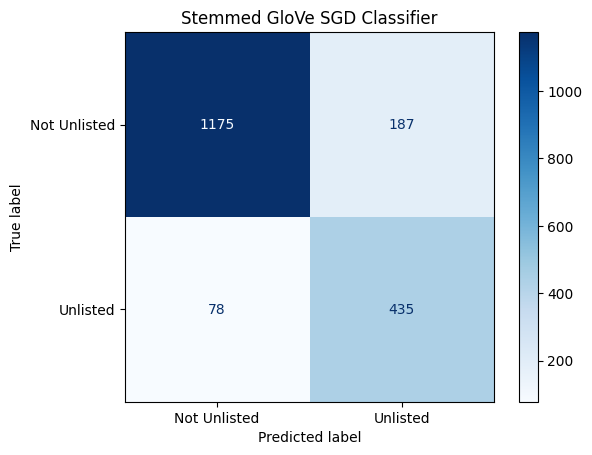

In [22]:
# Stochastic Gradient Descent

sgd = SGDClassifier(loss="hinge", penalty="l2", max_iter=1000, class_weight="balanced",\
     random_state=42, fit_intercept=False, tol=0.001, early_stopping=True, validation_fraction=0.1, \
        n_iter_no_change=5, n_jobs=-1, verbose=1, shuffle=True, learning_rate="adaptive", eta0=0.000001)

sgd.fit(sentence_vecs_train, target_train)

predictions_sgd = sgd.predict(sentence_vecs_test)

sgd_classif_report = classification_report(target_test, predictions_sgd)


print("\n \n Lemmatized GloVe SGD Classifier \n \n")

print(sgd_classif_report)

print("\n \n")

plot_conf_matrix(target_test, predictions_sgd, labels=["Not Unlisted", "Unlisted"], plot_name="Lemmatized GloVe SGD Classifier")


 
 Stemmed GloVe SGD Classifier 
 

              precision    recall  f1-score   support

           0       0.94      0.87      0.90      1362
           1       0.70      0.85      0.77       513

    accuracy                           0.86      1875
   macro avg       0.82      0.86      0.83      1875
weighted avg       0.87      0.86      0.86      1875


 



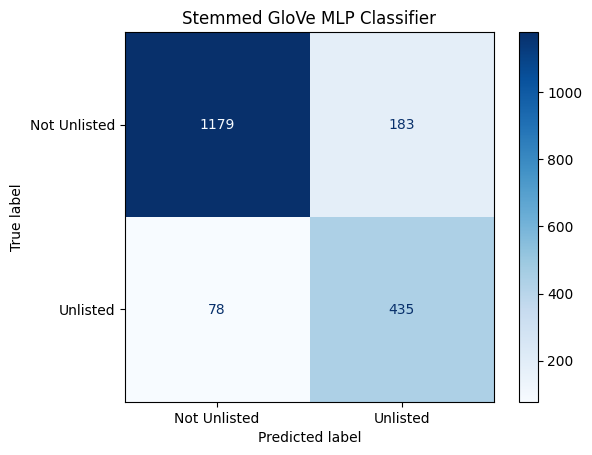

In [23]:
# Multi-Layer Perceptron (MLP)

mlp = MLPClassifier(solver='adam', hidden_layer_sizes=(2,2), activation='logistic', random_state=42)

mlp.fit(sentence_vecs_train, target_train)

predictions_mlp = mlp.predict(sentence_vecs_test)

mlp_classif_report = classification_report(target_test, predictions_mlp)


print("\n \n Lemmatized GloVe MLP Classifier \n \n")

print(mlp_classif_report)

print("\n \n")

plot_conf_matrix(target_test, predictions_mlp, labels=["Not Unlisted", "Unlisted"], plot_name="Lemmatized GloVe MLP Classifier")

#### Other Advanced Models - Random Forest and HistGradientBoosting

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished



 
 Stemmed GloVe Random Forest Classifier 
 

              precision    recall  f1-score   support

           0       0.94      0.87      0.90      1362
           1       0.70      0.85      0.77       513

    accuracy                           0.86      1875
   macro avg       0.82      0.86      0.83      1875
weighted avg       0.87      0.86      0.86      1875


 



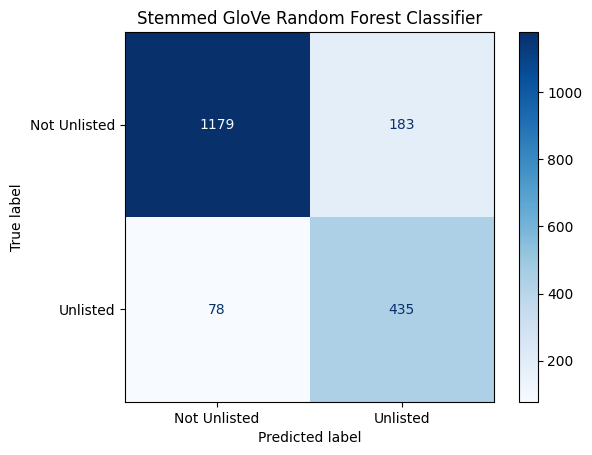

In [24]:
# Random Forest

rf_classifier = RandomForestClassifier(random_state=42, n_jobs=-1, class_weight="balanced", verbose=1)

rf_classifier.fit(sentence_vecs_train, target_train)

predictions_rf = rf_classifier.predict(sentence_vecs_test)

rf_classif_report = classification_report(target_test, predictions_rf)



print("\n \n Lemmatized GloVe Random Forest Classifier \n \n")

print(rf_classif_report)

print("\n \n")

plot_conf_matrix(target_test, predictions_rf, labels=["Not Unlisted", "Unlisted"], plot_name="Lemmatized GloVe Random Forest Classifier")

Binning 0.010 GB of training data: 0.628 s
Fitting gradient boosted rounds:
[1/100] 1 tree, 31 leaves, max depth = 11, in 0.037s
[2/100] 1 tree, 31 leaves, max depth = 11, in 0.056s
[3/100] 1 tree, 31 leaves, max depth = 11, in 0.044s
[4/100] 1 tree, 31 leaves, max depth = 10, in 0.033s
[5/100] 1 tree, 31 leaves, max depth = 10, in 0.036s
[6/100] 1 tree, 31 leaves, max depth = 12, in 0.034s
[7/100] 1 tree, 31 leaves, max depth = 12, in 0.037s
[8/100] 1 tree, 31 leaves, max depth = 11, in 0.033s
[9/100] 1 tree, 31 leaves, max depth = 10, in 0.054s
[10/100] 1 tree, 31 leaves, max depth = 10, in 0.046s
[11/100] 1 tree, 31 leaves, max depth = 11, in 0.045s
[12/100] 1 tree, 31 leaves, max depth = 10, in 0.041s
[13/100] 1 tree, 31 leaves, max depth = 10, in 0.040s
[14/100] 1 tree, 31 leaves, max depth = 11, in 0.036s
[15/100] 1 tree, 31 leaves, max depth = 10, in 0.039s
[16/100] 1 tree, 31 leaves, max depth = 10, in 0.036s
[17/100] 1 tree, 31 leaves, max depth = 10, in 0.039s
[18/100] 1 tree

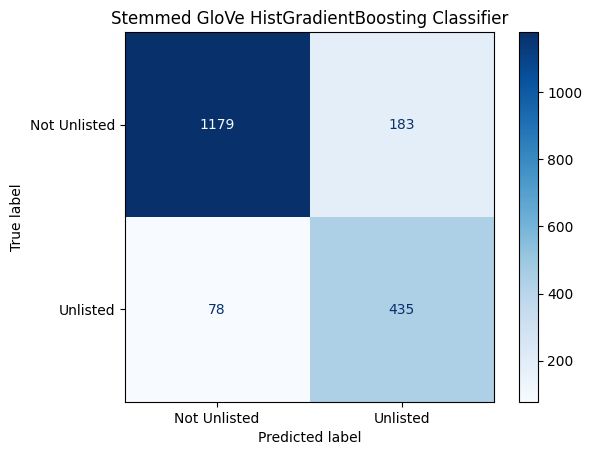

In [25]:
# HistGradientBoosting

hist_grad_boost = HistGradientBoostingClassifier(random_state=42, verbose=1)

hist_grad_boost.fit(sentence_vecs_train, target_train)

predictions_histgradboost = hist_grad_boost.predict(sentence_vecs_test)

histgradboost_classif_report = classification_report(target_test, predictions_histgradboost)


print("\n \n Lemmatized GloVe HistGradientBoosting Classifier \n \n")

plot_conf_matrix(target_test, predictions_histgradboost, labels=["Not Unlisted", "Unlisted"], plot_name="Lemmatized GloVe HistGradientBoosting Classifier")

In [26]:
# Classification report
print("\n \n")
print(histgradboost_classif_report)


 

              precision    recall  f1-score   support

           0       0.94      0.87      0.90      1362
           1       0.70      0.85      0.77       513

    accuracy                           0.86      1875
   macro avg       0.82      0.86      0.83      1875
weighted avg       0.87      0.86      0.86      1875



# Part 3 - Stemming + BERT + Classification (All models)

https://huggingface.co/google-bert/bert-base-uncased

In [27]:
df_train = pd.read_csv("df_train_split_stm.csv")
df_test = pd.read_csv("df_test_split_stm.csv")

## BERT

In [28]:
notebook_login()

In [29]:
def get_embeddings_bert(dataframe:pd.DataFrame, model_name:str="google-bert/bert-base-uncased", max_length:int=512):
    copy_df = dataframe.copy()
    
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    tokenizer = AutoTokenizer.from_pretrained(model_name)

    model = AutoModel.from_pretrained(model_name).to(device)

    def get_actual_embeddings(text,model_obj, tokenizer_obj, max_length=512):

        inputs = tokenizer_obj(text, return_tensors="pt", truncation=True, padding=True, max_length=max_length).to(device)
        outputs = model_obj(**inputs)
        cls_embeddings = outputs.last_hidden_state[:,0,:].detach().cpu().numpy()
        mean_embeddings = outputs.last_hidden_state.mean(dim=1).detach().cpu().numpy()

        return cls_embeddings, mean_embeddings
    
    cls_embeddings_dict = {}
    mean_embeddings_dict = {}

    # use tqdm to know how much time left
    for row_index, row in tqdm(copy_df.iterrows(), total=len(copy_df)):
        listing_id = row["listing_id"]
        comment = str(row["comments"])
        unlisted = row["unlisted"]

        cls_embeddings, mean_embeddings = get_actual_embeddings(comment, model, tokenizer, max_length)
        cls_embeddings_dict[listing_id] = {"embeddings":cls_embeddings, "target":unlisted}
        mean_embeddings_dict[listing_id] = {"embeddings":mean_embeddings, "target":unlisted}
        
    # save the embeddings on a column

    return cls_embeddings_dict, mean_embeddings_dict

In [ ]:
cls_train_embeddings, mean_train_embeddings = get_embeddings_bert(df_train, model_name="google-bert/bert-base-uncased", max_length=512)

In [ ]:
cls_test_embeddings, mean_test_embeddings = get_embeddings_bert(df_test, model_name="google-bert/bert-base-uncased", max_length=512)

In [ ]:
# prepare embeddings for models - TRAIN
cls_train_embeddings = np.array([cls_train_embeddings[key]["embeddings"] for key in cls_train_embeddings.keys()])
cls_train_embeddings = cls_train_embeddings.reshape(cls_train_embeddings.shape[0], mean_train_embeddings.shape[2])

# target
cls_train_embeddings_target = np.array([cls_train_embeddings[key]["target"] for key in cls_train_embeddings.keys()])
cls_train_embeddings_target = cls_train_embeddings_target.reshape(-1,1)

In [ ]:
# prepare embeddings for models - TEST
cls_test_embeddings = np.array([cls_test_embeddings[key]["embeddings"] for key in cls_test_embeddings.keys()])
cls_test_embeddings = cls_test_embeddings.reshape(cls_test_embeddings.shape[0], mean_train_embeddings.shape[2])

# target
cls_test_embeddings_target = np.array([cls_test_embeddings[key]["target"] for key in cls_train_embeddings.keys()])
cls_test_embeddings_target = cls_test_embeddings_target.reshape(-1,1)

In [ ]:
cls_train_embeddings.shape, cls_train_embeddings_target.shape

In [ ]:
cls_test_embeddings.shape, cls_test_embeddings_target.shape

# Models

In [ ]:
# Logistic Regression

lr = LogisticRegression(class_weight="balanced", random_state=42, n_jobs=-1)

lr.fit(cls_train_embeddings, cls_train_embeddings_target)

predictions_lr = lr.predict(cls_test_embeddings)

lr_classif_report = classification_report(cls_test_embeddings_target, predictions_lr)


print("\n \n Stemmed BERT Logistic Regression Classifier \n \n")

print(lr_classif_report)

print("\n \n")

plot_conf_matrix(cls_test_embeddings_target, predictions_lr, labels=["Not Unlisted", "Unlisted"], plot_name="Stemmed BERT Logistic Regression Classifier")


In [ ]:
# K-Nearest Neighbors

knn = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)

knn.fit(cls_train_embeddings, cls_train_embeddings_target)

predictions_knn = knn.predict(cls_test_embeddings)

knn_classif_report = classification_report(cls_test_embeddings_target, predictions_knn)


print("\n \n Stemmed BERT KNN Classifier \n \n")

print(knn_classif_report)

print("\n \n")

plot_conf_matrix(cls_test_embeddings_target, predictions_knn, labels=["Not Unlisted", "Unlisted"], plot_name="Stemmed BERT KNN Classifier")

In [ ]:
# Stochastic Gradient Descent

sgd = SGDClassifier(loss="hinge", penalty="l2", max_iter=1000, class_weight="balanced",\
     random_state=42, fit_intercept=False, tol=0.001, early_stopping=True, validation_fraction=0.1, \
        n_iter_no_change=5, n_jobs=-1, verbose=1, shuffle=True, learning_rate="adaptive", eta0=0.000001)

sgd.fit(cls_train_embeddings, cls_train_embeddings_target)

predictions_sgd = sgd.predict(cls_test_embeddings)

sgd_classif_report = classification_report(cls_test_embeddings_target, predictions_sgd)


print("\n \n Stemmed BERT SGD Classifier \n \n")

print(sgd_classif_report)

print("\n \n")

plot_conf_matrix(cls_test_embeddings_target, predictions_sgd, labels=["Not Unlisted", "Unlisted"], plot_name="Stemmed BERT SGD Classifier")

In [ ]:
# Multi-Layer Perceptron (MLP)

mlp = MLPClassifier(solver='adam', hidden_layer_sizes=(2,2), activation='logistic', random_state=42)

mlp.fit(cls_train_embeddings, cls_train_embeddings_target)

predictions_mlp = mlp.predict(cls_test_embeddings)

mlp_classif_report = classification_report(cls_test_embeddings_target, predictions_mlp)


print("\n \n Stemmed BERT SGD Classifier \n \n")

print(mlp_classif_report)

print("\n \n")

plot_conf_matrix(cls_test_embeddings_target, predictions_mlp, labels=["Not Unlisted", "Unlisted"], plot_name="Stemmed BERT MLP Classifier")

#### Other Advanced Models - Random Forest and HistGradientBoosting

In [ ]:
# Random Forest

rf_classifier = RandomForestClassifier(random_state=42, n_jobs=-1, class_weight="balanced", verbose=1)

rf_classifier.fit(cls_train_embeddings, cls_train_embeddings_target)

predictions_rf = rf_classifier.predict(cls_test_embeddings)

rf_classif_report = classification_report(cls_test_embeddings_target, predictions_rf)


print("\n \n Stemmed BERT Random Forest Classifier \n \n")

print(rf_classif_report)

print("\n \n")

plot_conf_matrix(cls_test_embeddings_target, predictions_rf, labels=["Not Unlisted", "Unlisted"], plot_name="Stemmed BERT Random Forest Classifier")

In [ ]:
# HistGradientBoosting

hist_grad_boost = HistGradientBoostingClassifier(random_state=42, verbose=1)

hist_grad_boost.fit(cls_train_embeddings.toarray(), cls_train_embeddings_target)

predictions_histgradboost = hist_grad_boost.predict(cls_test_embeddings.toarray())

histgradboost_classif_report = classification_report(cls_test_embeddings_target, predictions_histgradboost)


print("\n \n Stemmed BERT HistGradientBoosting Classifier \n \n")

print(histgradboost_classif_report)

print("\n \n")

plot_conf_matrix(cls_test_embeddings_target, predictions_histgradboost, labels=["Not Unlisted", "Unlisted"], plot_name="Stemmed BERTF Random Forest Classifier")

# Part 4: Prediction on test set with best model:  Lemmatized TF-IDF MLP Classifier

In [41]:
df_test = pd.read_csv("test_clean_merged.csv")

In [42]:
# Lemmatizing
updates = lemmatization(df_test["comments"])

update_df(df_test, updates)

100%|██████████| 695/695 [00:10<00:00, 69.27it/s] 


In [43]:
# Applying TF-IDF
test_data = tf_idf.transform(df_test["comments"])

In [44]:
# Generating predictions
predictions_mlp = mlp.predict(test_data)

In [45]:
predictions_mlp

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0,
       1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1,
       1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0,

In [46]:
df_test.shape

(695, 4)

In [47]:
len(predictions_mlp)

695

In [48]:
df_test.columns

Index(['listing_id', 'host_about', 'description', 'comments'], dtype='object')

In [51]:
df_test["predicted"] = predictions_mlp

In [52]:
df_test.head()

listing_id                                         host_about  \
0           1  like traveling meeting people like receiving f...   
1           2  home team count us take care every single deta...   
2           3  hi guestready professional property management...   
3           4                                                NaN   
4           5  welcome portugal love country also love gettin...   

                                         description  \
0  space apartment located historic center lisbon...   
1  important response covid 19 property extended ...   
2  bright beautiful spacious four bedroom apartme...   
3  charming apartment close bay cascais 1 bedroom...   
4  looking holiday close beach casino tourist att...   

                                            comments  prediction  predicted  
0  thank much antonio perfect stay appartment per...           0          0  
1  beautiful bright apartment residential area li...           0          0  
2                                       empty string           1          1  
3  claudia great host met u train station bring u...           0          0  
4  house exactly photo clean sheet towel smell li...           0          0

In [53]:
columns = ["listing_id","predicted"]

In [54]:
df_test = df_test[columns]

In [55]:
df_test

listing_id  predicted
0             1          0
1             2          0
2             3          1
3             4          0
4             5          0
..          ...        ...
690         691          0
691         692          0
692         693          1
693         694          0
694         695          0

[695 rows x 2 columns]

In [56]:
df_test.rename(columns={"listing_id":"id"}, inplace=True)

In [58]:
df_test.to_csv("Predictions_15.csv", sep = ",", index = False)

In [59]:
test = pd.read_csv("Predictions_15.csv")

In [61]:
test

id  predicted
0      1          0
1      2          0
2      3          1
3      4          0
4      5          0
..   ...        ...
690  691          0
691  692          0
692  693          1
693  694          0
694  695          0

[695 rows x 2 columns]